In [2]:
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git "pillow<7" ttach

In [1]:
!pip install torch --upgrade grad-cam

     |████████████████████████████████| 881.9 MB 5.5 kB/s                 |████████████████████            | 550.3 MB 42.7 MB/s eta 0:00:08
     |████████████████████████████████| 16.8 MB 18.7 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 23.3 MB 37.4 MB/s            
     |████████████████████████████████| 881.9 MB 5.0 kB/s             | 757.2 MB 45.5 MB/s eta 0:00:03��███████████████▊ | 847.2 MB 58.0 MB/s eta 0:00:01
  Created wheel for grad-cam: filename=grad_cam-1.3.9-py3-none-any.whl size=26084 sha256=6b4f854a850c5c27cbac94e3ba2cee1495227066baa0cc9fd0b196b755ab488d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/52/02/17/ad2d21956de344ee9596e75a6933f147c8cfd4913600644a36
Successfully built grad-cam
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstall

In [2]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import random
import json
import datetime
import time

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 

tqdm.pandas()

In [3]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
skills = dict(zip(skills.index, skills.values))

In [5]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
certs = dict(zip(certs.index, certs.values))

In [7]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [8]:
licenses = dict(zip(licenses.index, licenses.values))

In [9]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
languages = dict(zip(languages.index, languages.values))

In [11]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,90
84612,48
84731,3766
85437,3812
85627,1556


In [12]:
addresses = dict(zip(addresses.index, addresses.values))

In [13]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [14]:
df_pred = pd.read_csv("../Data/df_pred_ext.csv").drop("Unnamed: 0", axis=1)

In [15]:
df_pred = df_pred.drop(["time_between", "job_order", "source"], axis=1)

In [16]:
# df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()
df_pred["c"] = df_pred["candidate_id"]

In [17]:
# GRAD-cam requires a single input into forward(), so we need to include candidate in there as well
df_pred = df_pred[["candidate_id", "c", "time_spent", "isco_functie_niveau", "education", "company_name", "function_id", "isco_code4"]]

In [18]:
df_pred.head()

,candidate_id,c,time_spent,isco_functie_niveau,education,company_name,function_id,isco_code4
0,84556,84556,-0.210459,2.0,0.0,324258,936,208
1,84556,84556,-0.252626,1.0,0.0,324258,809,348
2,84556,84556,-0.085012,2.0,0.0,329244,936,208
3,84556,84556,-0.370694,1.0,0.0,368140,1519,344
4,84556,84556,-0.363314,1.0,0.0,419826,1519,344


In [19]:
majority_class = df_pred["isco_code4"].mode().values[0]

In [20]:
features = df_pred.columns[1:]

In [21]:
career_paths = df_pred.groupby("candidate_id")

In [22]:
candidate_lens = career_paths.apply(lambda x: len(x) - 1).to_dict()

In [23]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 7)

In [24]:
maximum_career_duration = 25

In [25]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:46<00:00, 10031.53it/s]


In [26]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [27]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [28]:
career_paths.head()

candidate_id
84556    [[84556.0, -0.21045870102048395, 2.0, 0.0, 324...
84612    [[84612.0, -0.3685852264755267, 1.0, 0.0, 2017...
84731    [[84731.0, -0.35066422025728855, 1.0, 0.0, 353...
85437    [[85437.0, 0.3313881928721292, 1.0, 2.0, 5500....
85888    [[85888.0, -0.2895219637480053, 2.0, 3.0, 4233...
dtype: object

In [29]:
idxs = []
x = []
y = []

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):       
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [30]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [31]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [32]:
del df_pred
del x
del career_paths

In [33]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [34]:
len(to_fill), len(y)

(113724, 113724)

In [35]:
# to_fill = to_fill[:25000]
# y = y[:25000]

In [36]:
def create_loaders(to_fill, idxs, y, split_size=0.8, weight_type=3, batch_size=512):

    # Train test split
    split = split_size

    training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
    test = np.array(list(set(range(len(to_fill))) - set(training)))

    train_indices, val_indices = idxs[training], idxs[test]
    X_train, X_val = to_fill[training], to_fill[test]
    y_train, y_val = y[training].astype(int), y[test].astype(int)

    # Class weights
    counts = (np.bincount(y_train) + 1)
    
    if weight_type == 1:
        labels_weights = 1. / counts
    elif weight_type == 2:
        labels_weights = 1. / np.sqrt(counts)
    elif weight_type == 3:
        labels_weights = 2. / (0.5 * np.sqrt(counts))
    else:
        return NotImplemented
        
    weights = labels_weights[y_train]
    sampler = WeightedRandomSampler(weights, len(weights))

    # Create dataloaders
    train_data = TensorDataset(torch.Tensor(train_indices), 
                               torch.Tensor(X_train), 
                               torch.Tensor(y_train).type(torch.LongTensor))

    trainloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

    val_data = TensorDataset(torch.Tensor(val_indices),
                             torch.Tensor(X_val),
                             torch.Tensor(y_val).type(torch.LongTensor))

    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    return trainloader, valloader

In [37]:
class XCM(nn.Module):

    def __init__(self, num_classes, input_size, skills, certs, licenses, 
                 languages, addresses, w2v, candidate_lengths, max_len, 
                 F1=64, F2=16, window_size=0.2, skill_embedding_size=50, 
                 certs_embedding_size=20, license_embedding_size=3, 
                 language_embedding_size=10, address_embedding_size=25, 
                 function_embedding_size=50, isco4_embedding_size=25, 
                 education_embedding_size=3, isco_level_embedding_size=3, 
                 company_embedding_size=50, w2v_embedding_size=300):
        
        super(XCM, self).__init__()
              
        self.num_classes = num_classes
        self.input_size = input_size + w2v_embedding_size
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        self.skill_embedding_size = skill_embedding_size
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        self.certs_embedding_size = certs_embedding_size
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        self.license_embedding_size = license_embedding_size
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        self.language_embedding_size = language_embedding_size 
        
        self.w2v_embedding = nn.Linear(300, w2v_embedding_size, bias=False)
        self.w2v_embedding.weight.data = torch.randn_like(self.w2v_embedding.weight) 
        self.w2v_embedding_size = w2v_embedding_size
        
        # Address embedding
        self.address_embedding = nn.Embedding(4757, address_embedding_size)       
        self.address_embedding_size = address_embedding_size
        
        # Categorical feature embeddings
        self.function_embedding = nn.Embedding(2992, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
        
        self.function_embedding_size = function_embedding_size
        self.isco_code_embedding_size = isco4_embedding_size
        self.company_embedding_size = company_embedding_size
        self.education_embedding_size = education_embedding_size
        self.isco_level_embedding_size = isco_level_embedding_size
                
        # -6 --> embedded features get replaced
        N = self.input_size - 6 + skill_embedding_size + certs_embedding_size + \
            license_embedding_size + language_embedding_size + address_embedding_size + \
            function_embedding_size + isco4_embedding_size + company_embedding_size + \
            education_embedding_size + isco_level_embedding_size
        
        # Actual model
        window_size = int(max_len * window_size)
        D = N
        
        self.relu = nn.ReLU()
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.75)
        
        self.batchnorm = nn.BatchNorm2d(F1)  
        self.batchnorm2 = nn.BatchNorm2d(F2)
        self.conv2d = nn.Conv2d(in_channels=1,
                                out_channels=F1,
                                kernel_size=(window_size, 1),
                                stride=(1, 1),
                                padding="same")
        
        self._1x1 = nn.Conv2d(in_channels=F1, 
                              out_channels=1, 
                              kernel_size=(1, 1), # Maybe (100, 1, 1)?
                              stride=1)

        # Asymmetric padding to have a consistent shape for even and uneven window_sizes
        self.conv1d_padding = nn.ZeroPad2d((0, 0, window_size // 2, (window_size - 1 ) // 2))

        self.conv1d = nn.Conv1d(in_channels=1,
                                out_channels=F1, 
                                kernel_size=(window_size, D),
                                stride=1)
                
        self._1x1_2 = nn.Conv1d(in_channels=F1, 
                                out_channels=1, 
                                kernel_size=(1, 1),
                                stride=1)
            
        self.final_conv1d = nn.Conv1d(in_channels=1,
                                      out_channels=F2, 
                                      kernel_size=(window_size, D + 1),
                                      stride=1,
                                      padding="same")
        
        self.avgpool2d = nn.AvgPool2d(kernel_size=(max_len, D + 1),
                                      stride=1)
        
        self.fc = nn.Linear(F2, num_classes)
                    
        self.softmax = nn.Softmax(dim=-1)
        
        # Skill lookup
        self.skills = skills
        
        # Certificate lookup
        self.certs = certs
        
        # License lookup
        self.licenses = licenses
        
        # Language lookup
        self.langs = languages
        
        # Address lookup
        self.adds = addresses
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len      
        
        def get_from_dict(x, cdict, N):
            return cdict.get(x, np.zeros((N,)))

        self.retrieve_static = np.vectorize(get_from_dict, otypes=[np.ndarray])   
                
    
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        actual_career_duration = career_duration
        career_duration = min(career_duration, max_len)
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = self.w2v_embedding(torch.Tensor(cvs[0]).to(device))
                w2v_list = torch.stack([w2v_list] * career_duration).to(device)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                
                to_skip = 0
                                
                # Make sure to use candidates' most recent max_len cvs
                if actual_career_duration > self.max_len:                                        
                    # Update to only include most recent max_len
                    ks -= max_len
                    
                    # Drop everything older than max_len time steps
                    ks_2 = np.array([ks[i] for i in range(len(ks)) if i < len(ks) and (i + 1 >= len(ks) or ks[i + 1] > 0)])
                    
                    # Store how many we need to skip while indexing
                    to_skip = len(ks) - len(ks_2)
                    
                    # Update ks
                    ks = ks_2
                    ks[0] = 0
                    
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= min(self.max_len, career_duration)])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        # Figure out negative duration cause
                        storage.append(torch.stack([self.w2v_embedding(torch.Tensor(embed_values[i + to_skip]).to(device))] * duration, dim=0))
                else:
                    storage.append(self.w2v_embedding(torch.Tensor(cvs[0])))

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * self.w2v_embedding_size).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
    
    def create_tensor(self, x):
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * (self.skill_embedding_size + self.certs_embedding_size
                                            + self.license_embedding_size + self.language_embedding_size
                                            + self.address_embedding_size + self.w2v_embedding_size)).type(torch.LongTensor).to(device)
        
        candidate_features = []
        
        # Extract candidate_ids
        candidate = x[:,:,0][:,-1].cpu()
        
        # Everything else stays in x
        x = x[:,:,1:]
        
        skill_list = self.retrieve_static(candidate, self.skills, 317)
        skill_list = torch.LongTensor(np.stack(skill_list)).to(device)
        
        certs_list = self.retrieve_static(candidate, self.certs, 98)
        certs_list = torch.LongTensor(np.stack(certs_list)).to(device)
        
        license_list = self.retrieve_static(candidate, self.licenses, 8)
        license_list = torch.LongTensor(np.stack(license_list)).to(device)
        
        langs_list = self.retrieve_static(candidate, self.langs, 23)
        langs_list = torch.LongTensor(np.stack(langs_list)).to(device)
            
        address = self.retrieve_static(candidate, self.adds, 1)
        address = torch.LongTensor(np.stack(address)).to(device)
        
        # Embed every static feature
        skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                            self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                            self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                            self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
                
        # Combine and embed
        batch_features = torch.cat([skill_list, certs_list, 
                                    license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
        batch_addresses = self.address_embedding(address)[:,0,:]
        
        # For each candidate in the current batch
        for i, c in enumerate(candidate):
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]
            
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)
                                    
            # Reset to max_len
            career_duration = min(career_duration, max_len)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([feature_width] * (self.max_len - career_duration))                
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                        
            # Broadcast and add static features
            static_features = torch.stack([batch_features[i]] * career_duration).type(torch.LongTensor).to(device)
            address_emb = torch.stack([batch_addresses[i]] * career_duration).type(torch.LongTensor).to(device)
            
            # Combine w2v, static features, and address
            full_features = torch.cat([w2v_list, static_features, address_emb], dim=1)
                                    
            # Broadcast CV, static, and address to the correct length
            full_features = torch.cat([zeros, full_features], dim=0)
                    
            # Store result
            candidate_features.append(full_features)
                                
         # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
                
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, education, company_name, function_id, isco_code = [x[:,:,-5],
                                                                       x[:,:,-4],
                                                                       x[:,:,-3],
                                                                       x[:,:,-2],
                                                                       x[:,:,-1]]
        
        x = x[:,:,:-5].to(device)
        
        isco_level_smoothing = (isco_level != 0).unsqueeze(-1)
        education_smoothing = (education != 0).unsqueeze(-1)
        company_name_smoothing = (company_name != 0).unsqueeze(-1)
        function_id_smoothing = (function_id != 0).unsqueeze(-1)
        isco_code_smoothing = (isco_code != 0).unsqueeze(-1)
        
        isco_level, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)) * isco_level_smoothing,
                                                                        self.education_embedding(education.type(torch.LongTensor).to(device)) * education_smoothing,
                                                                        self.company_embedding(company_name.type(torch.LongTensor).to(device)) * company_name_smoothing,
                                                                        self.function_embedding(function_id.type(torch.LongTensor).to(device)) * function_id_smoothing,
                                                                        self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device)) * isco_code_smoothing]   
                
        # Add features
        x = torch.cat([x, isco_level, education, company_name, function_id, isco_code, additional_features], dim=2)     
                                    
        return x
        
 
    def forward(self, x):                       
        # Reshape to allow conv2D
        x = x.unsqueeze(-1)
        x = x.transpose(1, 3)
        x = x.transpose(2, 3)
                
        # Top part:
        x1 = self.conv2d(x)
        x1 = self.batchnorm(x1)
        x1 = self.relu1(x1)
        x1 = self._1x1(x1)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)

        # Bottom part: 
        x = self.conv1d_padding(x)
        x2 = self.conv1d(x)
        x2 = self.batchnorm(x2)
        x2 = self.relu2(x2)
        x2 = self._1x1_2(x2)
        x2 = self.relu(x2)
        x2 = self.dropout(x2)
        
        # Concatenate                
        x = torch.cat([x1, x2], dim=-1)
                
        # Conv 1D
        x = self.final_conv1d(x)
        x = self.batchnorm2(x)
                        
        # Global average pooling
        x = self.avgpool2d(x)
        
        x = x.flatten(start_dim=1)
        
        x = self.dropout(x)
                    
        x = self.fc(x)
                
        # softmax
        out = self.softmax(x)
        return x

In [38]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0
        
        for i, (candidate, career, job) in enumerate(trainloader):
            
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            optimizer.zero_grad()
            
            career = model.create_tensor(career)
            outputs = model(career)
                                    
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()       
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
               
        training_loss /= len(trainloader)
                
        stats = test_loop(valloader, model, criterion)
        
        done = int(time.time() - start)        
        print(f"Epoch duration: {int((done) // 60)}:{int((done) % 60):02d}")
        
        with open(f"../logs/eCNN-LSTM/{datetime.now().strftime('%Y_%d_%m_%H:%M:%S')}.txt", "w+") as f:
            f.write(f"{model}\n\nEpoch: {epoch + 1}\n\nAcc@1: {stats[0]}\n\nDuration: {int(done // 60)}:{int(done % 60):02d}")
        
        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        results["training_loss"].append(training_loss)
        results["duration"].append(done)

        scheduler.step()
                
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
        
        plt.plot(passed, training_losses, label="Training Loss")
        plt.plot(passed, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.legend()
        plt.show()
                
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            
            career = model.create_tensor(career)
            pred = model(career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
                    
    # print("\nValidation:", Counter(np.array(pred.argmax(1).cpu())))
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}")
    
    return acc1, acc5, acc10, acc20, test_loss

In [39]:
torch.cuda.empty_cache()

In [40]:
sns.set_style("white")

Current iteration 0/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Epoch: 1, batch: 178/178, loss: 5.53436
Test Error:
Acc@1: 9.69%, Acc@5: 32.61%, Acc@10: 46.59%, Acc@20: 60.44% Avg loss: 5.196412
Epoch duration: 2:02


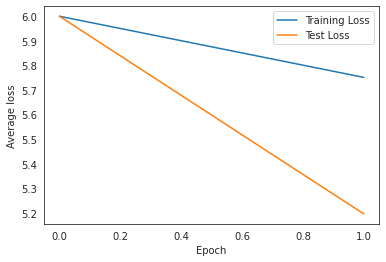

-------------------------------------------------------------------------------
Epoch starting at: 11:38:49
Epoch: 2, batch: 178/178, loss: 5.32914
Test Error:
Acc@1: 10.86%, Acc@5: 38.42%, Acc@10: 51.43%, Acc@20: 65.76% Avg loss: 4.635139
Epoch duration: 2:03


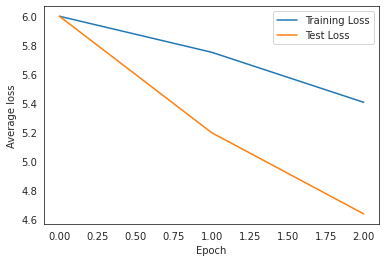

-------------------------------------------------------------------------------
Epoch starting at: 11:40:52
Epoch: 3, batch: 178/178, loss: 5.36883
Test Error:
Acc@1: 11.19%, Acc@5: 39.87%, Acc@10: 52.15%, Acc@20: 66.44% Avg loss: 4.593006
Epoch duration: 2:03


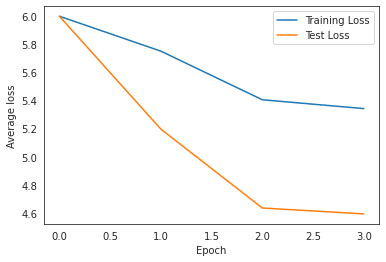

Current iteration 1/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv

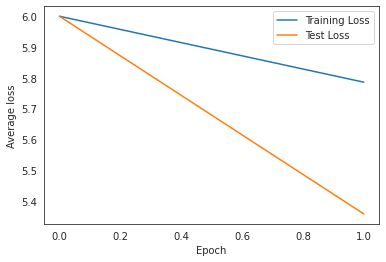

-------------------------------------------------------------------------------
Epoch starting at: 11:45:17
Epoch: 2, batch: 178/178, loss: 5.37364
Test Error:
Acc@1: 10.93%, Acc@5: 36.25%, Acc@10: 50.35%, Acc@20: 64.84% Avg loss: 4.664504
Epoch duration: 2:19


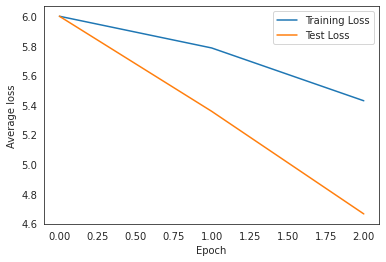

-------------------------------------------------------------------------------
Epoch starting at: 11:47:37
Epoch: 3, batch: 178/178, loss: 5.32657
Test Error:
Acc@1: 11.47%, Acc@5: 38.07%, Acc@10: 51.95%, Acc@20: 65.87% Avg loss: 4.614139
Epoch duration: 2:19


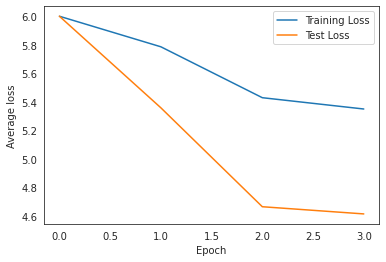

Current iteration 2/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv

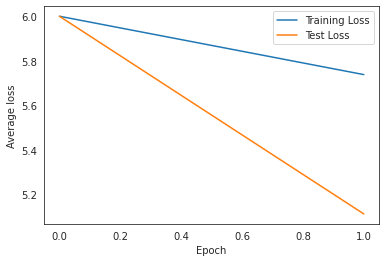

-------------------------------------------------------------------------------
Epoch starting at: 11:53:04
Epoch: 2, batch: 178/178, loss: 5.36557
Test Error:
Acc@1: 10.82%, Acc@5: 40.07%, Acc@10: 53.36%, Acc@20: 66.65% Avg loss: 4.610623
Epoch duration: 3:07


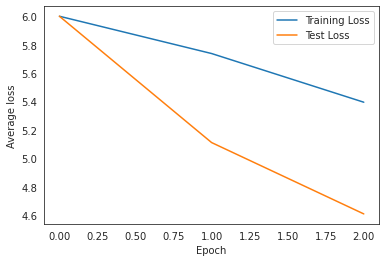

-------------------------------------------------------------------------------
Epoch starting at: 11:56:12
Epoch: 3, batch: 178/178, loss: 5.30581
Test Error:
Acc@1: 11.11%, Acc@5: 41.00%, Acc@10: 53.47%, Acc@20: 67.08% Avg loss: 4.581537
Epoch duration: 3:07


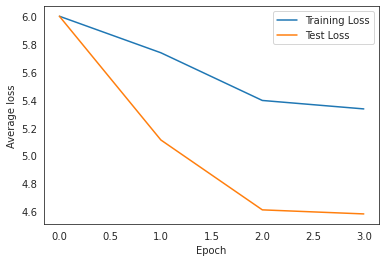

Current iteration 3/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv

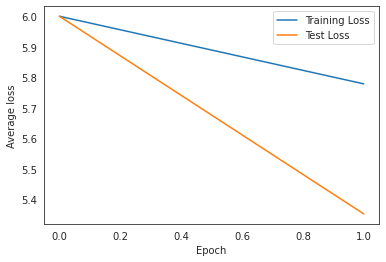

-------------------------------------------------------------------------------
Epoch starting at: 12:03:56
Epoch: 2, batch: 178/178, loss: 5.34183
Test Error:
Acc@1: 10.66%, Acc@5: 36.71%, Acc@10: 49.90%, Acc@20: 64.16% Avg loss: 4.668651
Epoch duration: 4:35


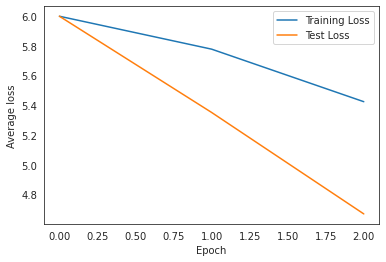

-------------------------------------------------------------------------------
Epoch starting at: 12:08:32
Epoch: 3, batch: 178/178, loss: 5.30968
Test Error:
Acc@1: 11.08%, Acc@5: 38.21%, Acc@10: 51.54%, Acc@20: 65.53% Avg loss: 4.608248
Epoch duration: 4:35


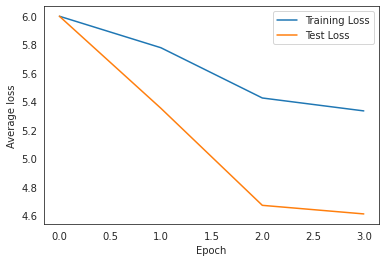

Current iteration 4/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv

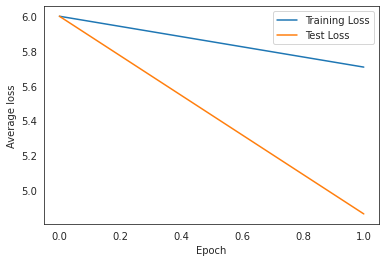

-------------------------------------------------------------------------------
Epoch starting at: 12:15:20
Epoch: 2, batch: 178/178, loss: 5.27766
Test Error:
Acc@1: 11.79%, Acc@5: 40.81%, Acc@10: 53.50%, Acc@20: 67.27% Avg loss: 4.503781
Epoch duration: 2:10


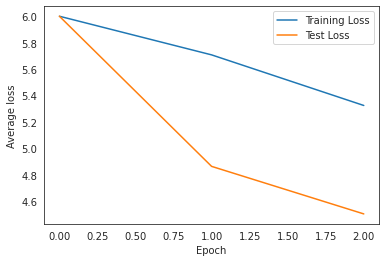

-------------------------------------------------------------------------------
Epoch starting at: 12:17:31
Epoch: 3, batch: 178/178, loss: 5.28684
Test Error:
Acc@1: 12.27%, Acc@5: 41.66%, Acc@10: 53.82%, Acc@20: 67.60% Avg loss: 4.500911
Epoch duration: 2:11


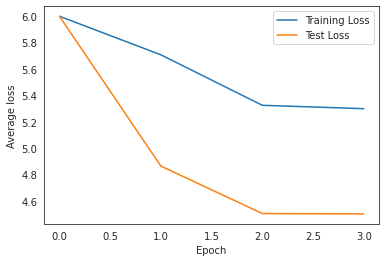

Current iteration 5/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv

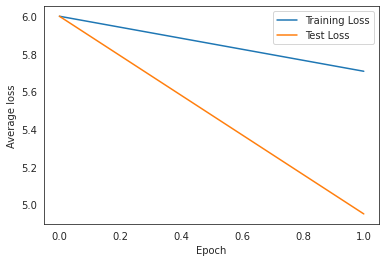

-------------------------------------------------------------------------------
Epoch starting at: 12:22:13
Epoch: 2, batch: 178/178, loss: 5.25381
Test Error:
Acc@1: 11.62%, Acc@5: 40.55%, Acc@10: 53.29%, Acc@20: 66.91% Avg loss: 4.526537
Epoch duration: 2:29


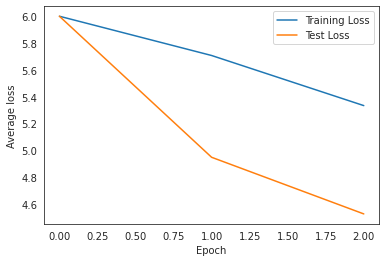

-------------------------------------------------------------------------------
Epoch starting at: 12:24:42
Epoch: 3, batch: 178/178, loss: 5.28343
Test Error:
Acc@1: 11.79%, Acc@5: 41.67%, Acc@10: 53.28%, Acc@20: 67.22% Avg loss: 4.498433
Epoch duration: 2:29


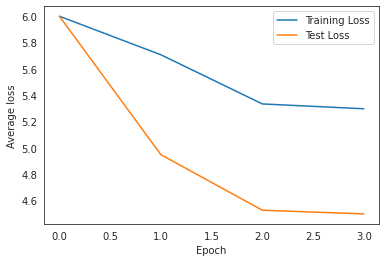

Current iteration 6/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv

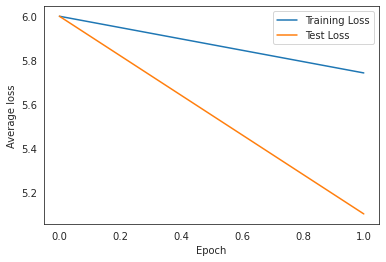

-------------------------------------------------------------------------------
Epoch starting at: 12:30:36
Epoch: 2, batch: 178/178, loss: 5.26887
Test Error:
Acc@1: 11.66%, Acc@5: 39.05%, Acc@10: 52.40%, Acc@20: 65.94% Avg loss: 4.547175
Epoch duration: 3:23


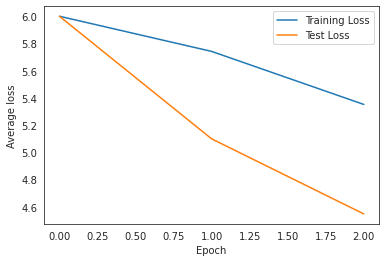

-------------------------------------------------------------------------------
Epoch starting at: 12:34:00
Epoch: 3, batch: 178/178, loss: 5.36721
Test Error:
Acc@1: 11.86%, Acc@5: 39.90%, Acc@10: 52.95%, Acc@20: 66.61% Avg loss: 4.519197
Epoch duration: 3:24


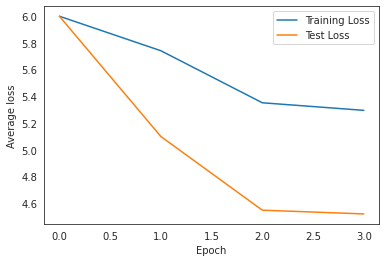

Current iteration 7/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv

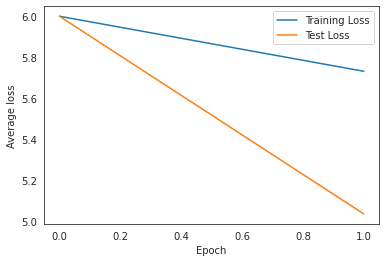

-------------------------------------------------------------------------------
Epoch starting at: 12:42:18
Epoch: 2, batch: 178/178, loss: 5.40494
Test Error:
Acc@1: 10.99%, Acc@5: 39.63%, Acc@10: 52.83%, Acc@20: 66.50% Avg loss: 4.531415
Epoch duration: 4:52


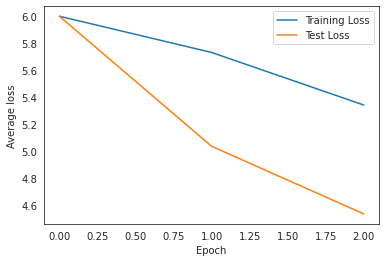

-------------------------------------------------------------------------------
Epoch starting at: 12:47:11
Epoch: 3, batch: 178/178, loss: 5.23614
Test Error:
Acc@1: 11.26%, Acc@5: 40.38%, Acc@10: 53.10%, Acc@20: 66.94% Avg loss: 4.507209
Epoch duration: 4:53


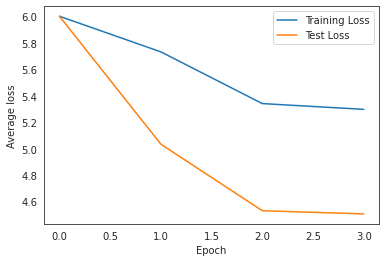

Current iteration 8/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv

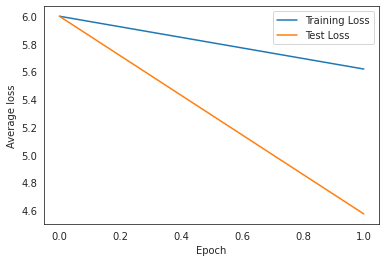

-------------------------------------------------------------------------------
Epoch starting at: 12:54:55
Epoch: 2, batch: 178/178, loss: 5.26533
Test Error:
Acc@1: 11.90%, Acc@5: 41.48%, Acc@10: 53.46%, Acc@20: 67.50% Avg loss: 4.443640
Epoch duration: 2:45


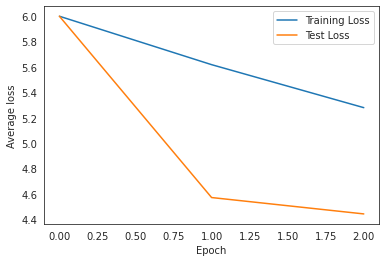

-------------------------------------------------------------------------------
Epoch starting at: 12:57:41
Epoch: 3, batch: 178/178, loss: 5.34701
Test Error:
Acc@1: 12.19%, Acc@5: 41.74%, Acc@10: 53.95%, Acc@20: 67.94% Avg loss: 4.441730
Epoch duration: 2:45


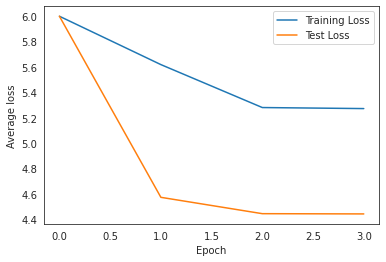

Current iteration 9/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv

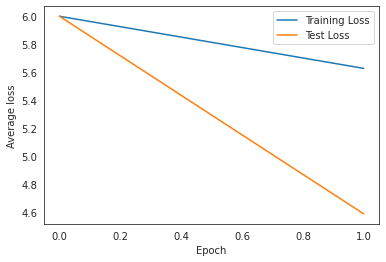

-------------------------------------------------------------------------------
Epoch starting at: 13:03:40
Epoch: 2, batch: 178/178, loss: 5.21589
Test Error:
Acc@1: 11.91%, Acc@5: 40.47%, Acc@10: 53.77%, Acc@20: 67.03% Avg loss: 4.453159
Epoch duration: 3:12


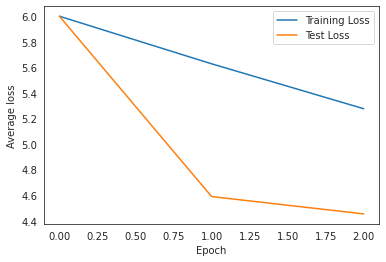

-------------------------------------------------------------------------------
Epoch starting at: 13:06:53
Epoch: 3, batch: 178/178, loss: 5.29366
Test Error:
Acc@1: 12.08%, Acc@5: 41.32%, Acc@10: 53.83%, Acc@20: 67.54% Avg loss: 4.446064
Epoch duration: 3:13


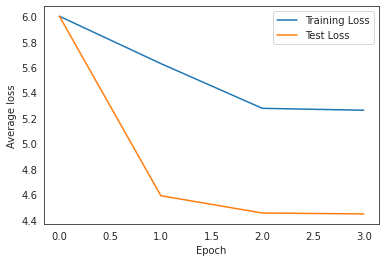

Current iteration 10/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

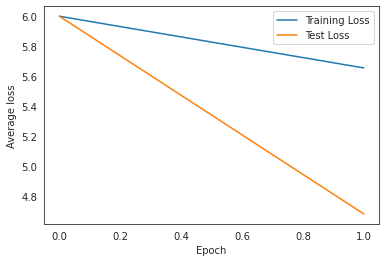

-------------------------------------------------------------------------------
Epoch starting at: 13:14:41
Epoch: 2, batch: 178/178, loss: 5.25238
Test Error:
Acc@1: 11.85%, Acc@5: 40.61%, Acc@10: 53.48%, Acc@20: 66.56% Avg loss: 4.464583
Epoch duration: 4:34


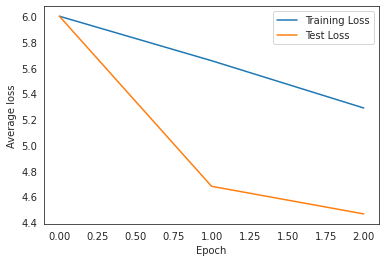

-------------------------------------------------------------------------------
Epoch starting at: 13:19:16
Epoch: 3, batch: 178/178, loss: 5.39686
Test Error:
Acc@1: 11.75%, Acc@5: 41.22%, Acc@10: 53.07%, Acc@20: 66.92% Avg loss: 4.446574
Epoch duration: 4:33


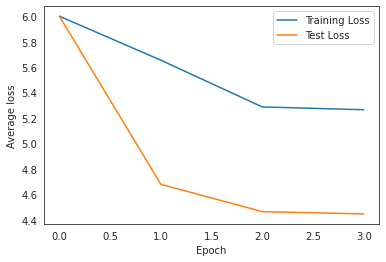

Current iteration 11/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

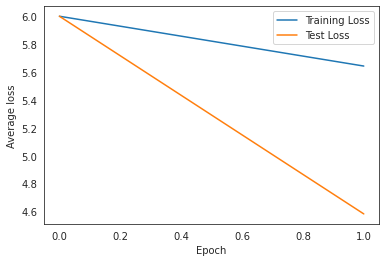

-------------------------------------------------------------------------------
Epoch starting at: 13:30:49
Epoch: 2, batch: 178/178, loss: 5.31940
Test Error:
Acc@1: 11.84%, Acc@5: 42.00%, Acc@10: 54.02%, Acc@20: 67.86% Avg loss: 4.453216
Epoch duration: 6:58


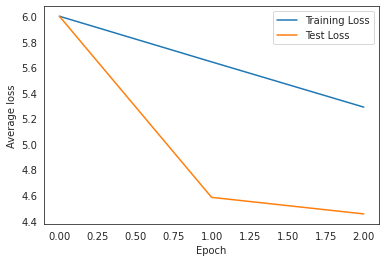

-------------------------------------------------------------------------------
Epoch starting at: 13:37:48
Epoch: 3, batch: 178/178, loss: 5.25977
Test Error:
Acc@1: 12.03%, Acc@5: 42.50%, Acc@10: 54.20%, Acc@20: 68.07% Avg loss: 4.445947
Epoch duration: 6:58


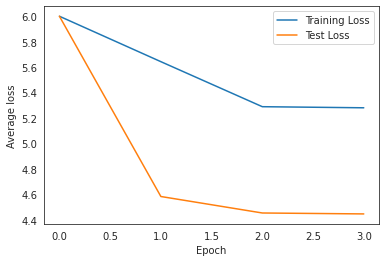

Current iteration 12/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

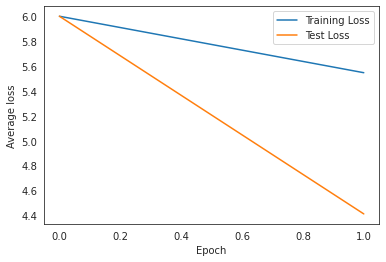

-------------------------------------------------------------------------------
Epoch starting at: 13:48:10
Epoch: 2, batch: 178/178, loss: 5.18119
Test Error:
Acc@1: 11.97%, Acc@5: 41.53%, Acc@10: 53.94%, Acc@20: 67.21% Avg loss: 4.426745
Epoch duration: 3:22


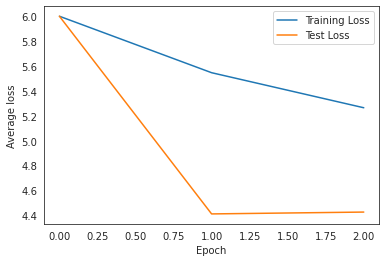

-------------------------------------------------------------------------------
Epoch starting at: 13:51:33
Epoch: 3, batch: 178/178, loss: 5.21005
Test Error:
Acc@1: 12.06%, Acc@5: 41.94%, Acc@10: 54.15%, Acc@20: 67.51% Avg loss: 4.418240
Epoch duration: 3:21


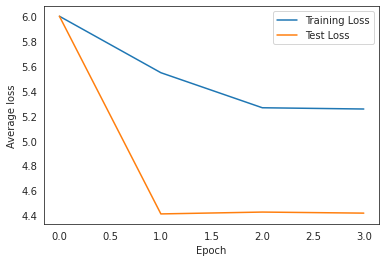

Current iteration 13/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

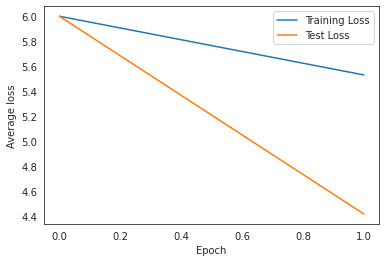

-------------------------------------------------------------------------------
Epoch starting at: 13:59:03
Epoch: 2, batch: 178/178, loss: 5.28804
Test Error:
Acc@1: 12.23%, Acc@5: 41.43%, Acc@10: 54.13%, Acc@20: 67.89% Avg loss: 4.407359
Epoch duration: 4:07


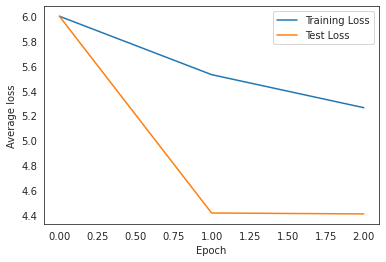

-------------------------------------------------------------------------------
Epoch starting at: 14:03:12
Epoch: 3, batch: 178/178, loss: 5.31117
Test Error:
Acc@1: 12.16%, Acc@5: 41.87%, Acc@10: 54.32%, Acc@20: 67.97% Avg loss: 4.409186
Epoch duration: 4:07


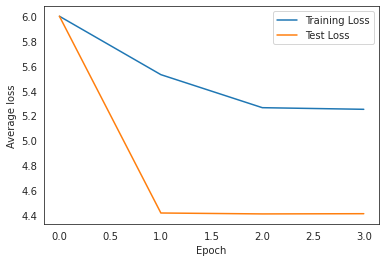

Current iteration 14/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

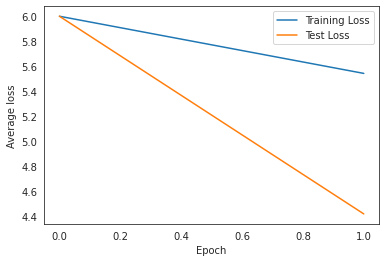

-------------------------------------------------------------------------------
Epoch starting at: 14:13:13
Epoch: 2, batch: 178/178, loss: 5.27354
Test Error:
Acc@1: 13.34%, Acc@5: 41.53%, Acc@10: 53.98%, Acc@20: 68.40% Avg loss: 4.401501
Epoch duration: 5:53


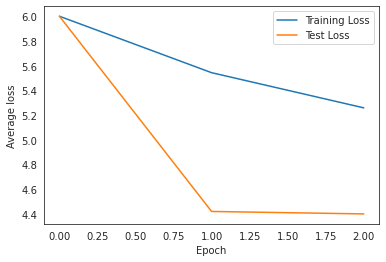

-------------------------------------------------------------------------------
Epoch starting at: 14:19:07
Epoch: 3, batch: 178/178, loss: 5.09293
Test Error:
Acc@1: 13.56%, Acc@5: 42.15%, Acc@10: 54.42%, Acc@20: 68.53% Avg loss: 4.357050
Epoch duration: 5:53


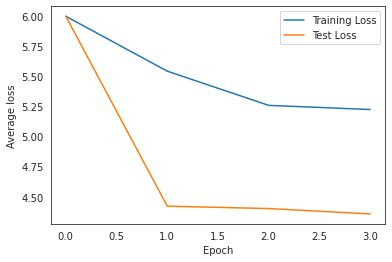

Current iteration 15/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

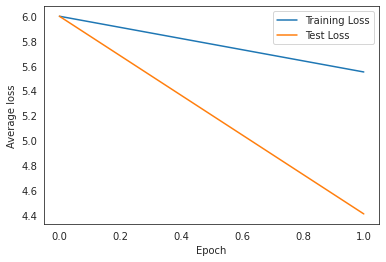

-------------------------------------------------------------------------------
Epoch starting at: 14:34:34
Epoch: 2, batch: 178/178, loss: 5.25459
Test Error:
Acc@1: 12.15%, Acc@5: 41.58%, Acc@10: 54.47%, Acc@20: 67.32% Avg loss: 4.401906
Epoch duration: 9:33


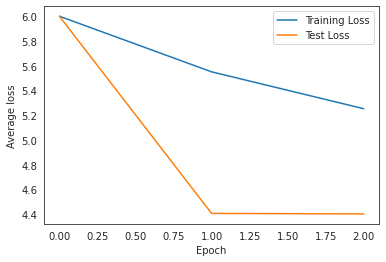

-------------------------------------------------------------------------------
Epoch starting at: 14:44:08
Epoch: 3, batch: 178/178, loss: 5.17718
Test Error:
Acc@1: 11.91%, Acc@5: 41.93%, Acc@10: 54.21%, Acc@20: 67.59% Avg loss: 4.413441
Epoch duration: 9:32


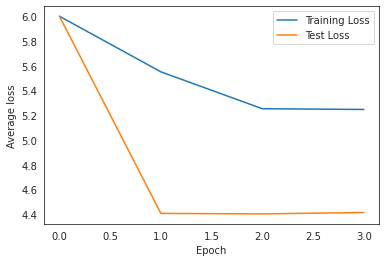

Current iteration 16/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

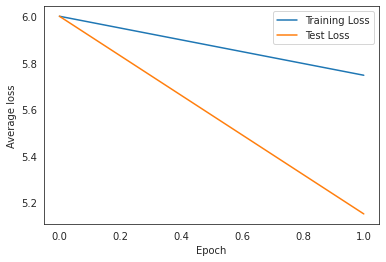

-------------------------------------------------------------------------------
Epoch starting at: 14:55:49
Epoch: 2, batch: 178/178, loss: 5.30423
Test Error:
Acc@1: 11.85%, Acc@5: 41.37%, Acc@10: 53.25%, Acc@20: 66.96% Avg loss: 4.602940
Epoch duration: 2:07


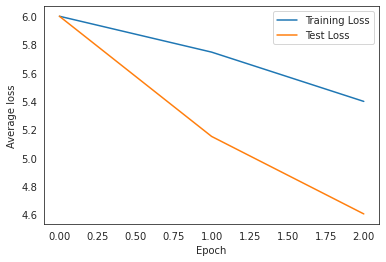

-------------------------------------------------------------------------------
Epoch starting at: 14:57:56
Epoch: 3, batch: 178/178, loss: 5.36998
Test Error:
Acc@1: 12.28%, Acc@5: 41.54%, Acc@10: 53.68%, Acc@20: 67.60% Avg loss: 4.563302
Epoch duration: 2:07


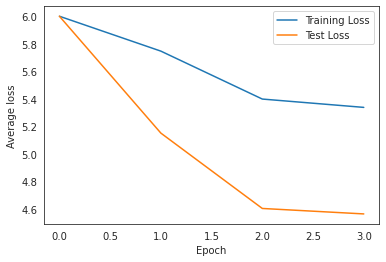

Current iteration 17/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

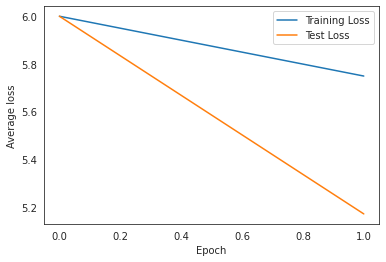

-------------------------------------------------------------------------------
Epoch starting at: 15:02:30
Epoch: 2, batch: 178/178, loss: 5.34983
Test Error:
Acc@1: 10.29%, Acc@5: 38.10%, Acc@10: 52.25%, Acc@20: 66.29% Avg loss: 4.632692
Epoch duration: 2:27


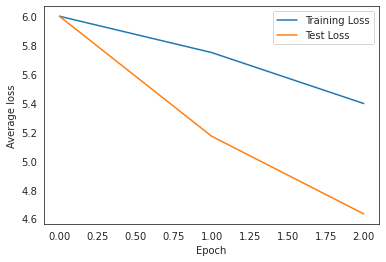

-------------------------------------------------------------------------------
Epoch starting at: 15:04:58
Epoch: 3, batch: 178/178, loss: 5.39015
Test Error:
Acc@1: 10.99%, Acc@5: 40.04%, Acc@10: 53.15%, Acc@20: 66.73% Avg loss: 4.589800
Epoch duration: 2:25


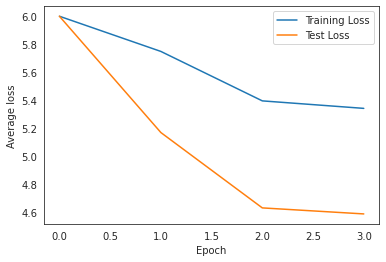

Current iteration 18/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

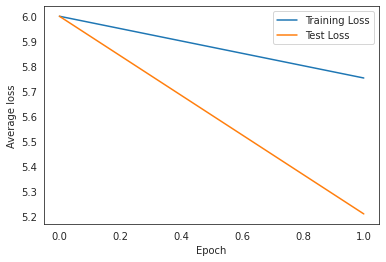

-------------------------------------------------------------------------------
Epoch starting at: 15:10:54
Epoch: 2, batch: 178/178, loss: 5.29840
Test Error:
Acc@1: 11.00%, Acc@5: 39.13%, Acc@10: 51.55%, Acc@20: 65.31% Avg loss: 4.629279
Epoch duration: 3:28


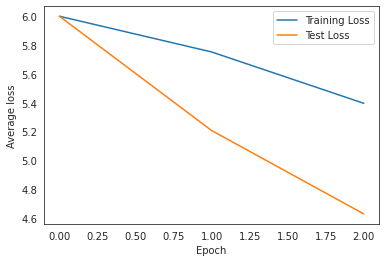

-------------------------------------------------------------------------------
Epoch starting at: 15:14:23
Epoch: 3, batch: 178/178, loss: 5.32805
Test Error:
Acc@1: 11.79%, Acc@5: 40.17%, Acc@10: 52.42%, Acc@20: 65.99% Avg loss: 4.585251
Epoch duration: 3:26


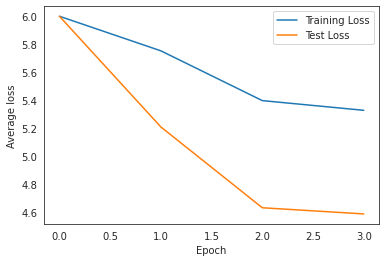

Current iteration 19/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

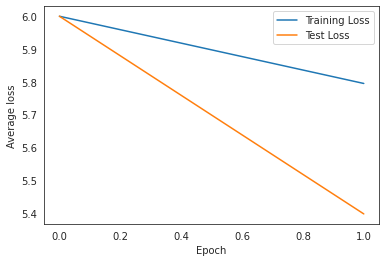

-------------------------------------------------------------------------------
Epoch starting at: 15:23:08
Epoch: 2, batch: 178/178, loss: 5.40595
Test Error:
Acc@1: 10.26%, Acc@5: 36.89%, Acc@10: 50.11%, Acc@20: 64.28% Avg loss: 4.670796
Epoch duration: 5:18


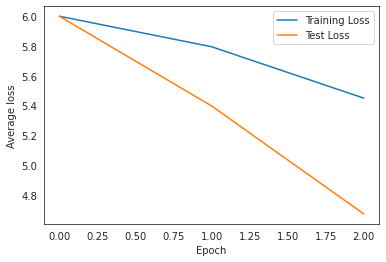

-------------------------------------------------------------------------------
Epoch starting at: 15:28:26
Epoch: 3, batch: 178/178, loss: 5.35032
Test Error:
Acc@1: 10.80%, Acc@5: 38.68%, Acc@10: 51.62%, Acc@20: 65.81% Avg loss: 4.601251
Epoch duration: 5:18


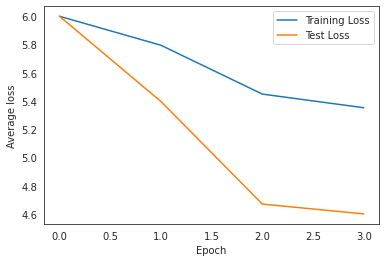

Current iteration 20/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

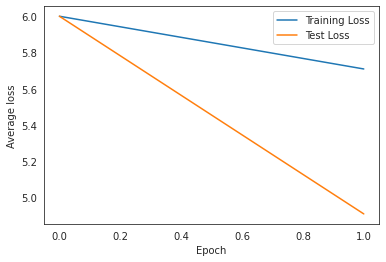

-------------------------------------------------------------------------------
Epoch starting at: 15:36:00
Epoch: 2, batch: 178/178, loss: 5.27477
Test Error:
Acc@1: 12.11%, Acc@5: 40.12%, Acc@10: 52.74%, Acc@20: 66.58% Avg loss: 4.517105
Epoch duration: 2:14


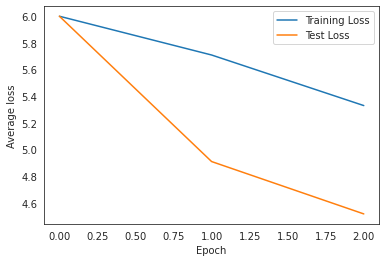

-------------------------------------------------------------------------------
Epoch starting at: 15:38:15
Epoch: 3, batch: 178/178, loss: 5.27339
Test Error:
Acc@1: 11.99%, Acc@5: 40.86%, Acc@10: 53.17%, Acc@20: 66.76% Avg loss: 4.506809
Epoch duration: 2:15


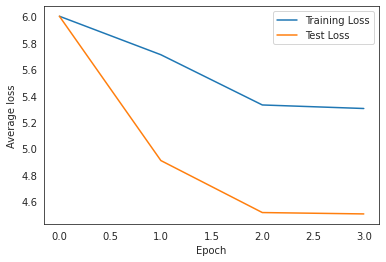

Current iteration 21/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

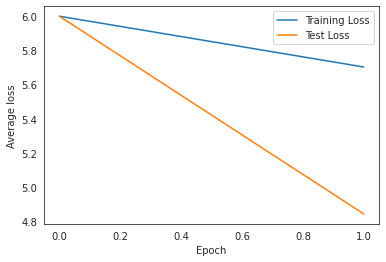

-------------------------------------------------------------------------------
Epoch starting at: 15:43:08
Epoch: 2, batch: 178/178, loss: 5.28841
Test Error:
Acc@1: 12.15%, Acc@5: 41.01%, Acc@10: 53.47%, Acc@20: 67.43% Avg loss: 4.502705
Epoch duration: 2:36


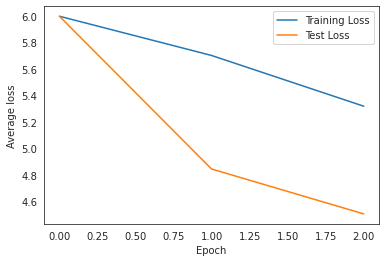

-------------------------------------------------------------------------------
Epoch starting at: 15:45:44
Epoch: 3, batch: 178/178, loss: 5.33776
Test Error:
Acc@1: 12.59%, Acc@5: 41.59%, Acc@10: 53.95%, Acc@20: 67.46% Avg loss: 4.485311
Epoch duration: 2:36


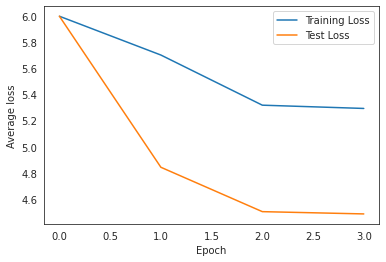

Current iteration 22/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

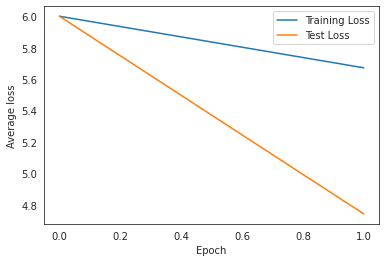

-------------------------------------------------------------------------------
Epoch starting at: 15:52:01
Epoch: 2, batch: 178/178, loss: 5.28110
Test Error:
Acc@1: 11.79%, Acc@5: 41.87%, Acc@10: 53.78%, Acc@20: 67.58% Avg loss: 4.501966
Epoch duration: 3:39


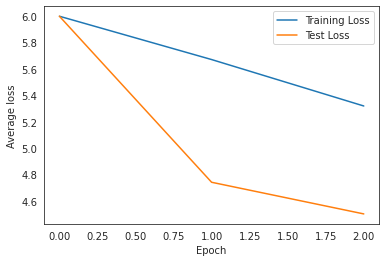

-------------------------------------------------------------------------------
Epoch starting at: 15:55:41
Epoch: 3, batch: 178/178, loss: 5.28203
Test Error:
Acc@1: 11.88%, Acc@5: 42.21%, Acc@10: 53.81%, Acc@20: 67.76% Avg loss: 4.497418
Epoch duration: 3:39


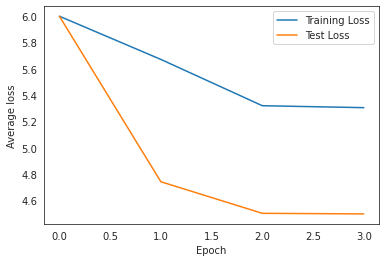

Current iteration 23/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

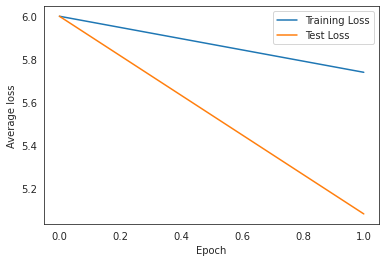

-------------------------------------------------------------------------------
Epoch starting at: 16:04:57
Epoch: 2, batch: 178/178, loss: 5.33641
Test Error:
Acc@1: 11.43%, Acc@5: 39.51%, Acc@10: 52.83%, Acc@20: 66.87% Avg loss: 4.537654
Epoch duration: 5:34


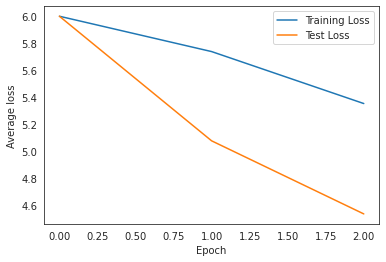

-------------------------------------------------------------------------------
Epoch starting at: 16:10:31
Epoch: 3, batch: 178/178, loss: 5.27262
Test Error:
Acc@1: 11.28%, Acc@5: 39.96%, Acc@10: 53.23%, Acc@20: 67.15% Avg loss: 4.513167
Epoch duration: 5:34


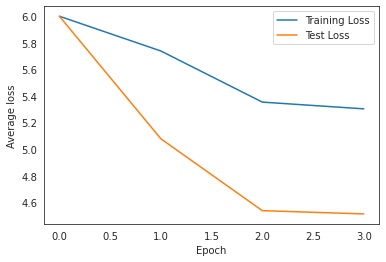

Current iteration 24/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

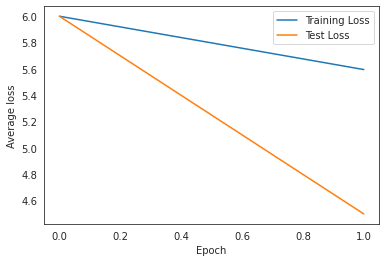

-------------------------------------------------------------------------------
Epoch starting at: 16:18:55
Epoch: 2, batch: 178/178, loss: 5.31316
Test Error:
Acc@1: 12.24%, Acc@5: 42.52%, Acc@10: 54.05%, Acc@20: 67.91% Avg loss: 4.438921
Epoch duration: 2:47


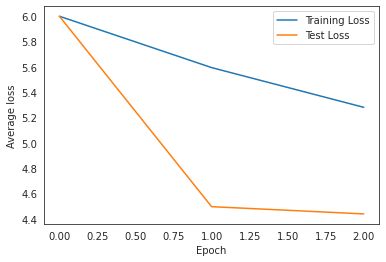

-------------------------------------------------------------------------------
Epoch starting at: 16:21:42
Epoch: 3, batch: 178/178, loss: 5.22282
Test Error:
Acc@1: 11.76%, Acc@5: 42.50%, Acc@10: 54.85%, Acc@20: 67.89% Avg loss: 4.419777
Epoch duration: 2:47


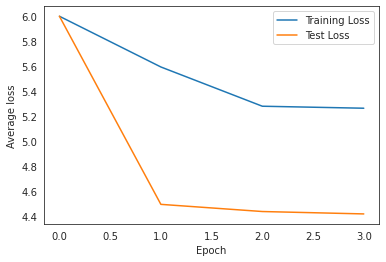

Current iteration 25/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

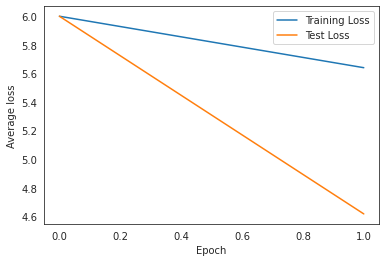

-------------------------------------------------------------------------------
Epoch starting at: 16:27:51
Epoch: 2, batch: 178/178, loss: 5.28349
Test Error:
Acc@1: 11.44%, Acc@5: 40.86%, Acc@10: 53.86%, Acc@20: 67.36% Avg loss: 4.451854
Epoch duration: 3:19


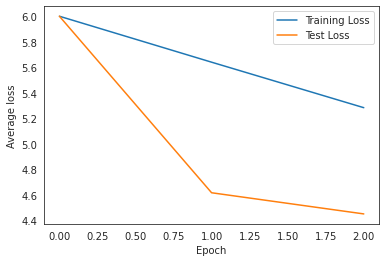

-------------------------------------------------------------------------------
Epoch starting at: 16:31:11
Epoch: 3, batch: 178/178, loss: 5.32847
Test Error:
Acc@1: 11.80%, Acc@5: 41.52%, Acc@10: 54.09%, Acc@20: 67.61% Avg loss: 4.451063
Epoch duration: 3:20


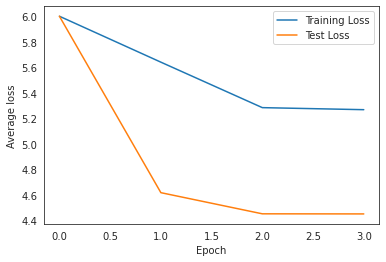

Current iteration 26/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

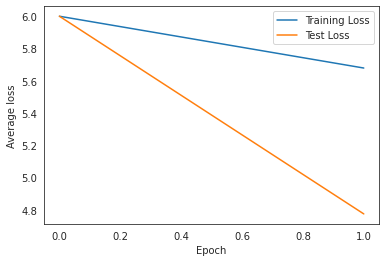

-------------------------------------------------------------------------------
Epoch starting at: 16:39:24
Epoch: 2, batch: 178/178, loss: 5.29793
Test Error:
Acc@1: 11.82%, Acc@5: 40.55%, Acc@10: 53.44%, Acc@20: 67.00% Avg loss: 4.470163
Epoch duration: 4:51


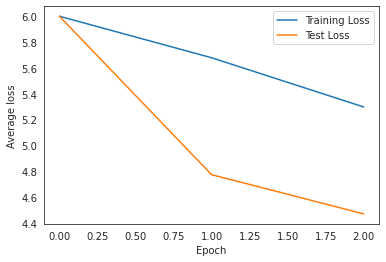

-------------------------------------------------------------------------------
Epoch starting at: 16:44:16
Epoch: 3, batch: 178/178, loss: 5.27544
Test Error:
Acc@1: 11.69%, Acc@5: 40.69%, Acc@10: 53.48%, Acc@20: 67.12% Avg loss: 4.458695
Epoch duration: 4:51


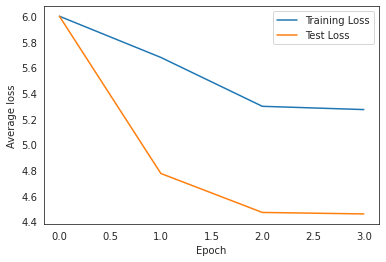

Current iteration 27/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

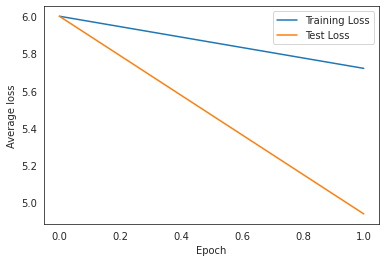

-------------------------------------------------------------------------------
Epoch starting at: 16:56:50
Epoch: 2, batch: 178/178, loss: 5.23517
Test Error:
Acc@1: 11.97%, Acc@5: 39.87%, Acc@10: 53.35%, Acc@20: 66.89% Avg loss: 4.460314
Epoch duration: 7:42


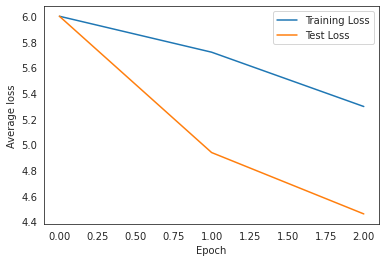

-------------------------------------------------------------------------------
Epoch starting at: 17:04:34
Epoch: 3, batch: 178/178, loss: 5.20366
Test Error:
Acc@1: 13.07%, Acc@5: 41.12%, Acc@10: 53.86%, Acc@20: 67.89% Avg loss: 4.406603
Epoch duration: 7:42


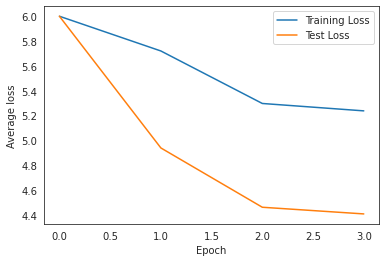

Current iteration 28/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

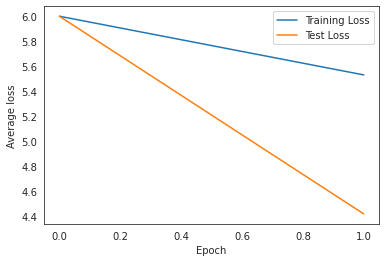

-------------------------------------------------------------------------------
Epoch starting at: 17:15:43
Epoch: 2, batch: 178/178, loss: 5.28188
Test Error:
Acc@1: 12.09%, Acc@5: 41.65%, Acc@10: 54.34%, Acc@20: 68.31% Avg loss: 4.402161
Epoch duration: 3:25


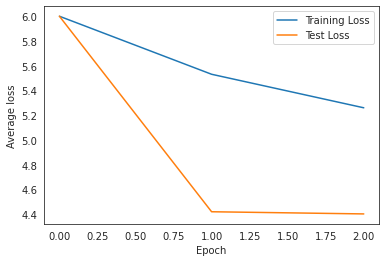

-------------------------------------------------------------------------------
Epoch starting at: 17:19:08
Epoch: 3, batch: 178/178, loss: 5.23160
Test Error:
Acc@1: 12.32%, Acc@5: 41.69%, Acc@10: 54.25%, Acc@20: 68.32% Avg loss: 4.412794
Epoch duration: 3:25


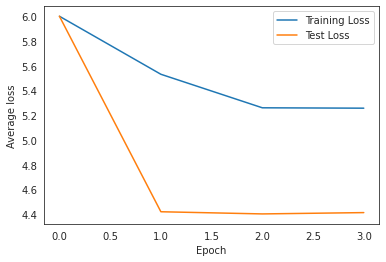

Current iteration 29/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

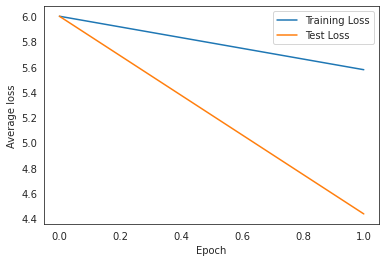

-------------------------------------------------------------------------------
Epoch starting at: 17:26:46
Epoch: 2, batch: 178/178, loss: 5.22165
Test Error:
Acc@1: 12.07%, Acc@5: 41.74%, Acc@10: 54.80%, Acc@20: 68.02% Avg loss: 4.404092
Epoch duration: 4:12


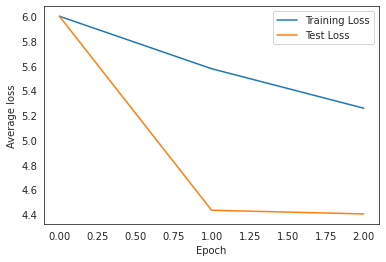

-------------------------------------------------------------------------------
Epoch starting at: 17:30:59
Epoch: 3, batch: 178/178, loss: 5.38491
Test Error:
Acc@1: 12.45%, Acc@5: 41.88%, Acc@10: 54.85%, Acc@20: 68.18% Avg loss: 4.398338
Epoch duration: 4:13


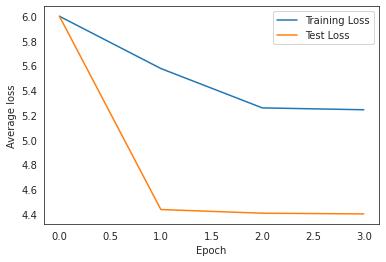

Current iteration 30/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

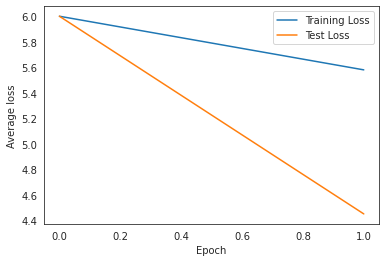

-------------------------------------------------------------------------------
Epoch starting at: 17:41:38
Epoch: 2, batch: 178/178, loss: 5.23358
Test Error:
Acc@1: 11.84%, Acc@5: 41.42%, Acc@10: 53.96%, Acc@20: 67.19% Avg loss: 4.420699
Epoch duration: 6:18


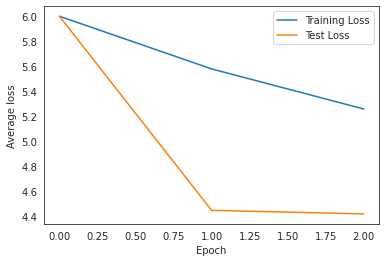

-------------------------------------------------------------------------------
Epoch starting at: 17:47:56
Epoch: 3, batch: 178/178, loss: 5.24941
Test Error:
Acc@1: 12.14%, Acc@5: 41.48%, Acc@10: 53.92%, Acc@20: 67.64% Avg loss: 4.427148
Epoch duration: 6:18


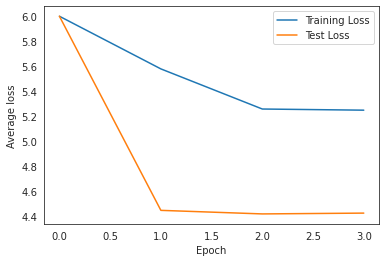

Current iteration 31/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

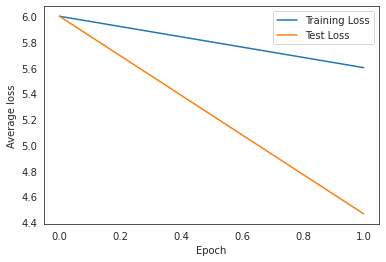

-------------------------------------------------------------------------------
Epoch starting at: 18:04:32
Epoch: 2, batch: 178/178, loss: 5.19960
Test Error:
Acc@1: 12.66%, Acc@5: 41.07%, Acc@10: 54.25%, Acc@20: 68.23% Avg loss: 4.378274
Epoch duration: 10:21


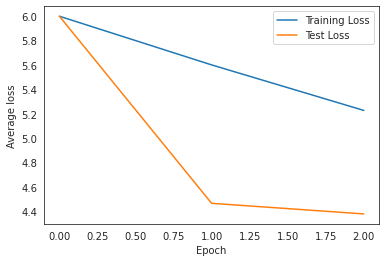

-------------------------------------------------------------------------------
Epoch starting at: 18:14:54
Epoch: 3, batch: 178/178, loss: 5.14014
Test Error:
Acc@1: 13.21%, Acc@5: 41.72%, Acc@10: 54.30%, Acc@20: 68.71% Avg loss: 4.343714
Epoch duration: 10:12


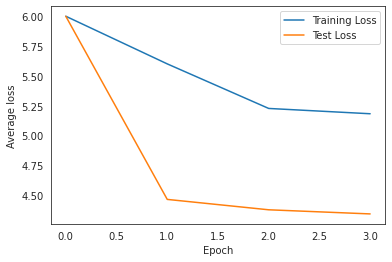

Current iteration 32/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

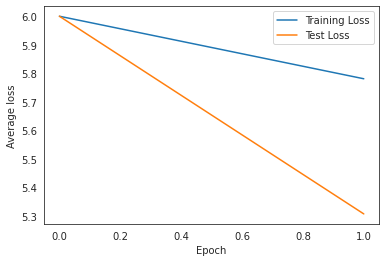

-------------------------------------------------------------------------------
Epoch starting at: 18:27:20
Epoch: 2, batch: 178/178, loss: 5.33309
Test Error:
Acc@1: 10.39%, Acc@5: 37.48%, Acc@10: 51.59%, Acc@20: 65.21% Avg loss: 4.650989
Epoch duration: 2:13


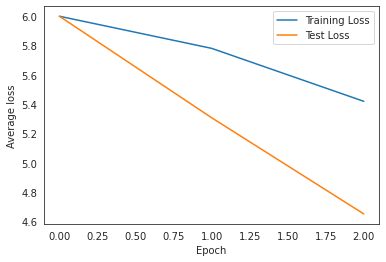

-------------------------------------------------------------------------------
Epoch starting at: 18:29:33
Epoch: 3, batch: 178/178, loss: 5.34411
Test Error:
Acc@1: 10.68%, Acc@5: 38.99%, Acc@10: 52.90%, Acc@20: 66.06% Avg loss: 4.592371
Epoch duration: 2:12


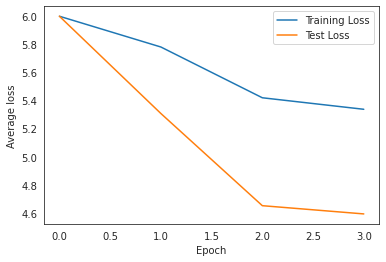

Current iteration 33/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

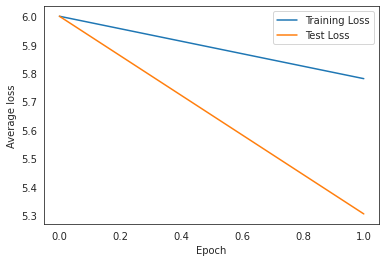

-------------------------------------------------------------------------------
Epoch starting at: 18:34:26
Epoch: 2, batch: 178/178, loss: 5.33829
Test Error:
Acc@1: 11.12%, Acc@5: 37.63%, Acc@10: 51.23%, Acc@20: 65.87% Avg loss: 4.641261
Epoch duration: 2:38


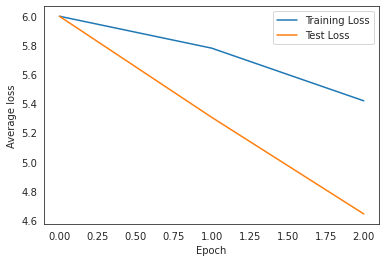

-------------------------------------------------------------------------------
Epoch starting at: 18:37:04
Epoch: 3, batch: 178/178, loss: 5.31189
Test Error:
Acc@1: 12.20%, Acc@5: 39.23%, Acc@10: 52.39%, Acc@20: 66.46% Avg loss: 4.592481
Epoch duration: 2:38


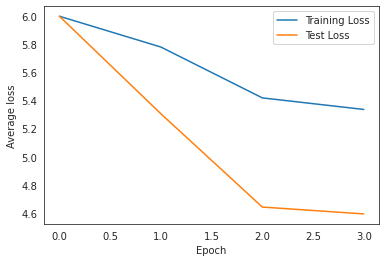

Current iteration 34/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

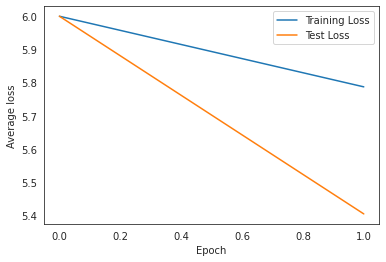

-------------------------------------------------------------------------------
Epoch starting at: 18:43:48
Epoch: 2, batch: 178/178, loss: 5.40184
Test Error:
Acc@1: 10.33%, Acc@5: 37.09%, Acc@10: 50.54%, Acc@20: 64.67% Avg loss: 4.677095
Epoch duration: 4:05


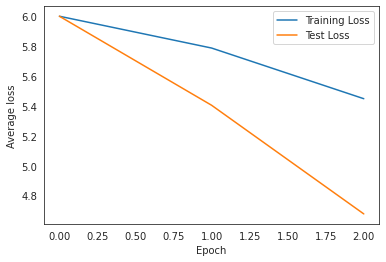

-------------------------------------------------------------------------------
Epoch starting at: 18:47:53
Epoch: 3, batch: 178/178, loss: 5.41448
Test Error:
Acc@1: 11.09%, Acc@5: 38.52%, Acc@10: 51.80%, Acc@20: 66.10% Avg loss: 4.606364
Epoch duration: 4:05


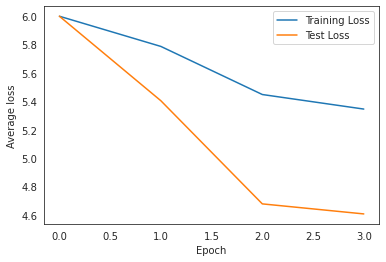

Current iteration 35/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

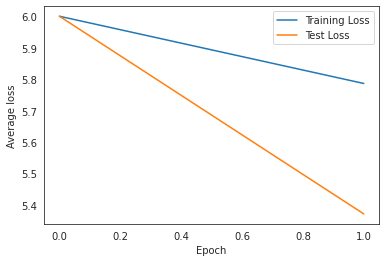

-------------------------------------------------------------------------------
Epoch starting at: 18:58:41
Epoch: 2, batch: 178/178, loss: 5.37155
Test Error:
Acc@1: 11.32%, Acc@5: 37.24%, Acc@10: 50.58%, Acc@20: 64.86% Avg loss: 4.660114
Epoch duration: 6:40


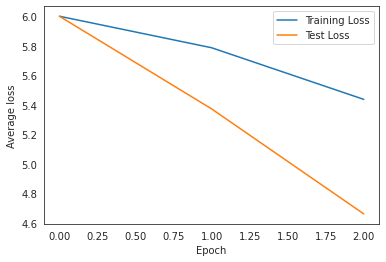

-------------------------------------------------------------------------------
Epoch starting at: 19:05:22
Epoch: 3, batch: 178/178, loss: 5.23682
Test Error:
Acc@1: 11.58%, Acc@5: 38.71%, Acc@10: 51.94%, Acc@20: 66.11% Avg loss: 4.585482
Epoch duration: 6:40


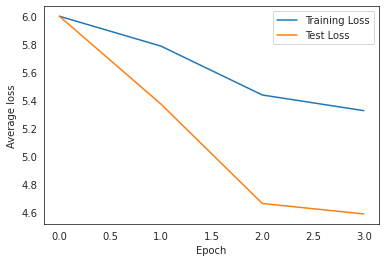

Current iteration 36/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

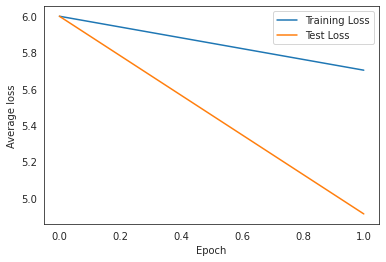

-------------------------------------------------------------------------------
Epoch starting at: 19:14:25
Epoch: 2, batch: 178/178, loss: 5.33662
Test Error:
Acc@1: 12.22%, Acc@5: 40.84%, Acc@10: 53.78%, Acc@20: 67.49% Avg loss: 4.511967
Epoch duration: 2:21


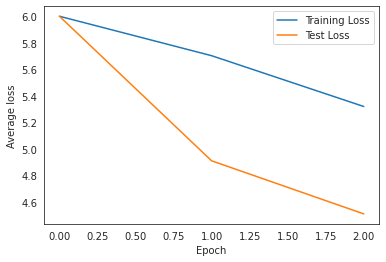

-------------------------------------------------------------------------------
Epoch starting at: 19:16:46
Epoch: 3, batch: 178/178, loss: 5.26561
Test Error:
Acc@1: 11.91%, Acc@5: 41.59%, Acc@10: 53.90%, Acc@20: 67.76% Avg loss: 4.493842
Epoch duration: 2:21


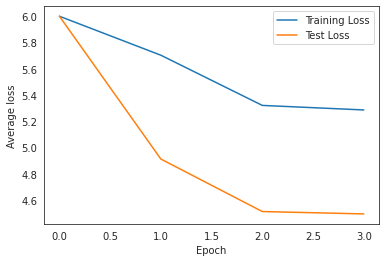

Current iteration 37/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

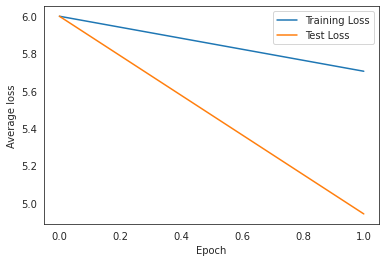

-------------------------------------------------------------------------------
Epoch starting at: 19:21:58
Epoch: 2, batch: 178/178, loss: 5.32900
Test Error:
Acc@1: 11.81%, Acc@5: 40.13%, Acc@10: 53.10%, Acc@20: 67.03% Avg loss: 4.525387
Epoch duration: 2:49


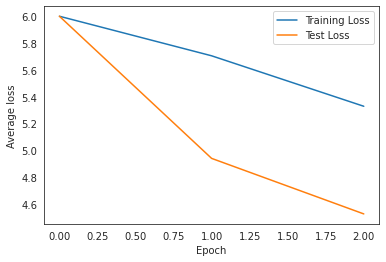

-------------------------------------------------------------------------------
Epoch starting at: 19:24:47
Epoch: 3, batch: 178/178, loss: 5.29150
Test Error:
Acc@1: 11.95%, Acc@5: 41.18%, Acc@10: 53.89%, Acc@20: 67.30% Avg loss: 4.498767
Epoch duration: 2:49


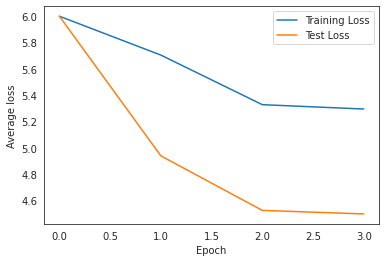

Current iteration 38/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

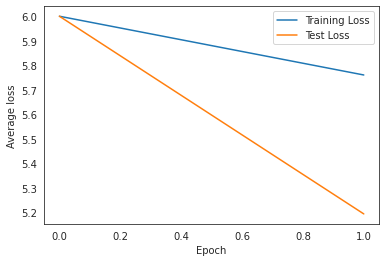

-------------------------------------------------------------------------------
Epoch starting at: 19:31:54
Epoch: 2, batch: 178/178, loss: 5.30471
Test Error:
Acc@1: 11.80%, Acc@5: 38.98%, Acc@10: 52.20%, Acc@20: 66.31% Avg loss: 4.560099
Epoch duration: 4:17


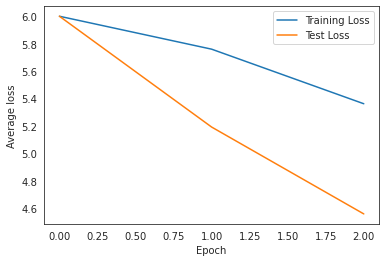

-------------------------------------------------------------------------------
Epoch starting at: 19:36:12
Epoch: 3, batch: 178/178, loss: 5.31006
Test Error:
Acc@1: 11.43%, Acc@5: 40.34%, Acc@10: 53.09%, Acc@20: 66.82% Avg loss: 4.513040
Epoch duration: 4:17


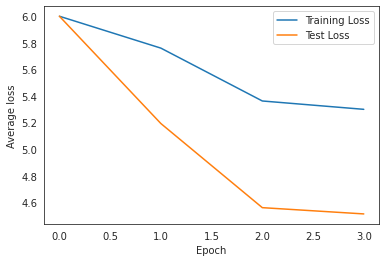

Current iteration 39/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

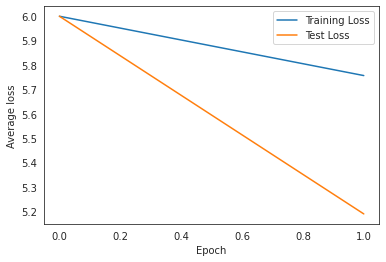

-------------------------------------------------------------------------------
Epoch starting at: 19:47:28
Epoch: 2, batch: 178/178, loss: 5.21410
Test Error:
Acc@1: 11.80%, Acc@5: 39.60%, Acc@10: 52.73%, Acc@20: 66.93% Avg loss: 4.523081
Epoch duration: 6:57


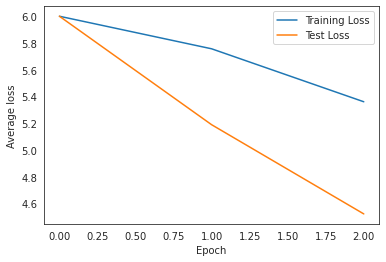

-------------------------------------------------------------------------------
Epoch starting at: 19:54:25
Epoch: 3, batch: 178/178, loss: 5.19610
Test Error:
Acc@1: 12.63%, Acc@5: 40.73%, Acc@10: 53.68%, Acc@20: 67.31% Avg loss: 4.490567
Epoch duration: 6:57


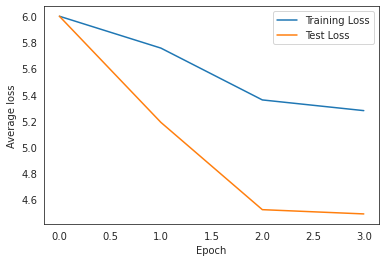

Current iteration 40/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

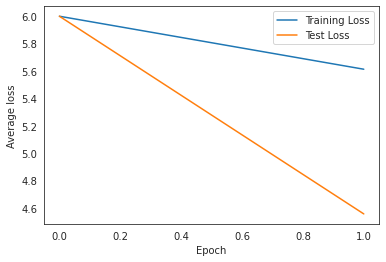

-------------------------------------------------------------------------------
Epoch starting at: 20:04:17
Epoch: 2, batch: 178/178, loss: 5.25396
Test Error:
Acc@1: 11.96%, Acc@5: 41.43%, Acc@10: 53.67%, Acc@20: 67.71% Avg loss: 4.456501
Epoch duration: 2:53


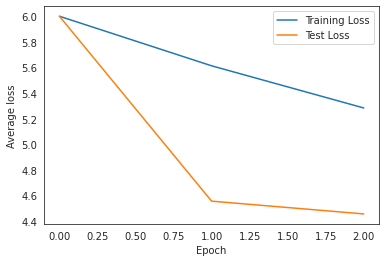

-------------------------------------------------------------------------------
Epoch starting at: 20:07:12
Epoch: 3, batch: 178/178, loss: 5.22156
Test Error:
Acc@1: 12.00%, Acc@5: 41.52%, Acc@10: 53.77%, Acc@20: 67.28% Avg loss: 4.454735
Epoch duration: 2:54


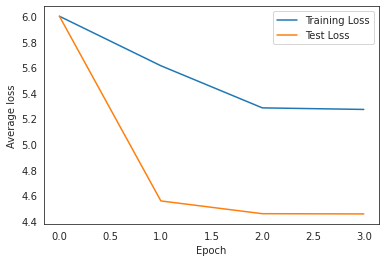

Current iteration 41/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

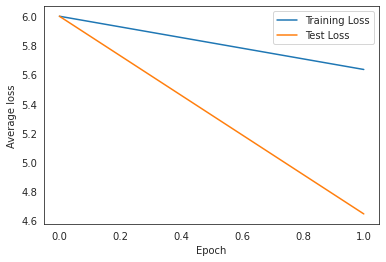

-------------------------------------------------------------------------------
Epoch starting at: 20:13:40
Epoch: 2, batch: 178/178, loss: 5.28193
Test Error:
Acc@1: 11.71%, Acc@5: 40.28%, Acc@10: 52.84%, Acc@20: 67.44% Avg loss: 4.464136
Epoch duration: 3:34


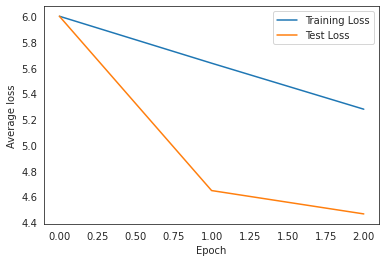

-------------------------------------------------------------------------------
Epoch starting at: 20:17:15
Epoch: 3, batch: 178/178, loss: 5.25743
Test Error:
Acc@1: 12.02%, Acc@5: 40.93%, Acc@10: 53.82%, Acc@20: 67.64% Avg loss: 4.443413
Epoch duration: 3:33


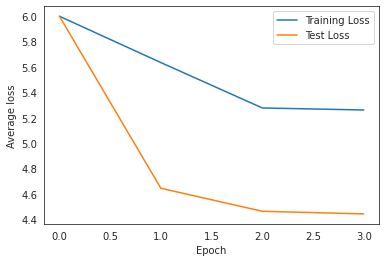

Current iteration 42/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

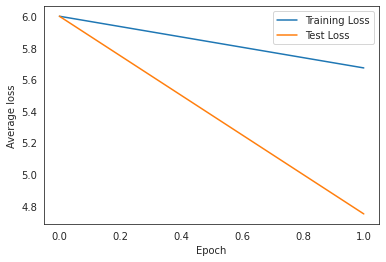

-------------------------------------------------------------------------------
Epoch starting at: 20:26:15
Epoch: 2, batch: 178/178, loss: 5.23522
Test Error:
Acc@1: 11.79%, Acc@5: 40.03%, Acc@10: 53.04%, Acc@20: 67.27% Avg loss: 4.474300
Epoch duration: 5:25


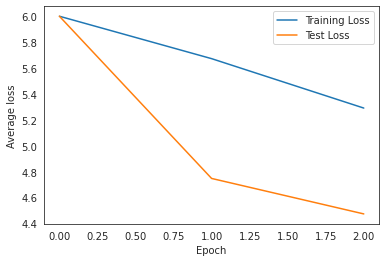

-------------------------------------------------------------------------------
Epoch starting at: 20:31:40
Epoch: 3, batch: 178/178, loss: 5.29189
Test Error:
Acc@1: 12.52%, Acc@5: 41.20%, Acc@10: 53.36%, Acc@20: 67.90% Avg loss: 4.428505
Epoch duration: 5:25


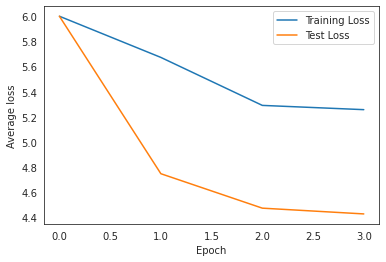

Current iteration 43/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

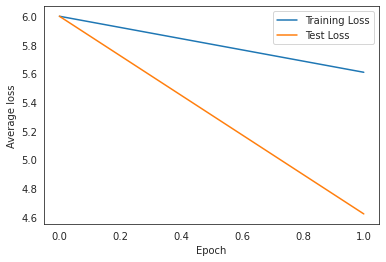

-------------------------------------------------------------------------------
Epoch starting at: 20:46:10
Epoch: 2, batch: 178/178, loss: 5.22432
Test Error:
Acc@1: 11.48%, Acc@5: 41.33%, Acc@10: 54.16%, Acc@20: 67.01% Avg loss: 4.408742
Epoch duration: 9:02


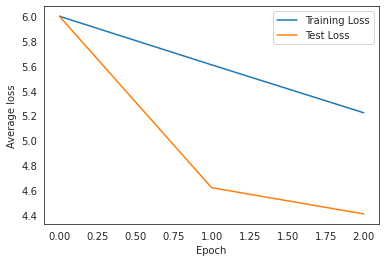

-------------------------------------------------------------------------------
Epoch starting at: 20:55:13
Epoch: 3, batch: 178/178, loss: 5.17953
Test Error:
Acc@1: 12.00%, Acc@5: 41.23%, Acc@10: 54.28%, Acc@20: 67.07% Avg loss: 4.396508
Epoch duration: 9:02


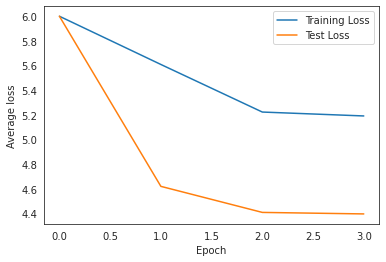

Current iteration 44/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

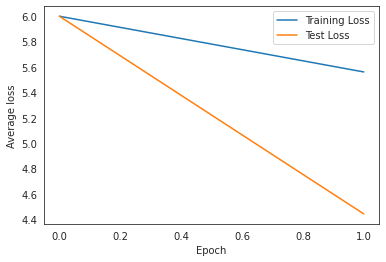

-------------------------------------------------------------------------------
Epoch starting at: 21:07:47
Epoch: 2, batch: 178/178, loss: 5.23402
Test Error:
Acc@1: 13.33%, Acc@5: 41.78%, Acc@10: 55.03%, Acc@20: 68.32% Avg loss: 4.394262
Epoch duration: 3:30


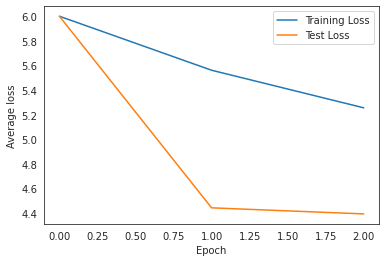

-------------------------------------------------------------------------------
Epoch starting at: 21:11:18
Epoch: 3, batch: 178/178, loss: 5.13696
Test Error:
Acc@1: 13.33%, Acc@5: 42.57%, Acc@10: 55.36%, Acc@20: 68.64% Avg loss: 4.383891
Epoch duration: 3:30


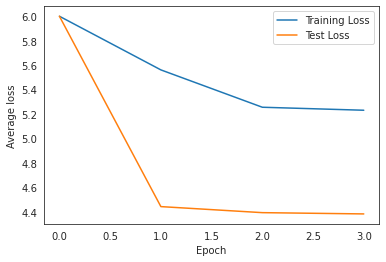

Current iteration 45/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

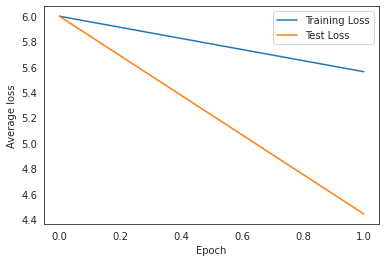

-------------------------------------------------------------------------------
Epoch starting at: 21:19:18
Epoch: 2, batch: 178/178, loss: 5.15342
Test Error:
Acc@1: 12.45%, Acc@5: 41.35%, Acc@10: 54.12%, Acc@20: 68.18% Avg loss: 4.406548
Epoch duration: 4:27


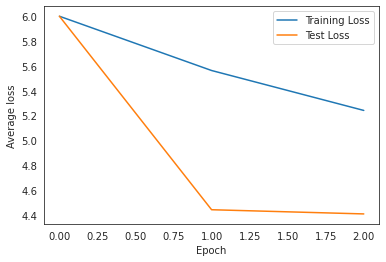

-------------------------------------------------------------------------------
Epoch starting at: 21:23:46
Epoch: 3, batch: 178/178, loss: 5.23180
Test Error:
Acc@1: 12.92%, Acc@5: 41.38%, Acc@10: 54.26%, Acc@20: 68.23% Avg loss: 4.379236
Epoch duration: 4:27


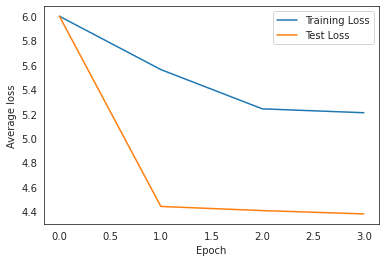

Current iteration 46/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

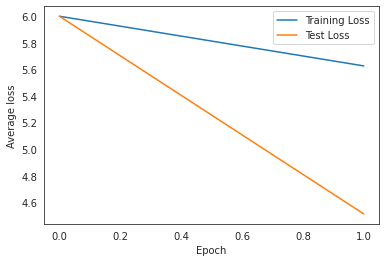

-------------------------------------------------------------------------------
Epoch starting at: 21:35:01
Epoch: 2, batch: 178/178, loss: 5.25137
Test Error:
Acc@1: 12.06%, Acc@5: 40.67%, Acc@10: 54.23%, Acc@20: 67.62% Avg loss: 4.414545
Epoch duration: 6:48


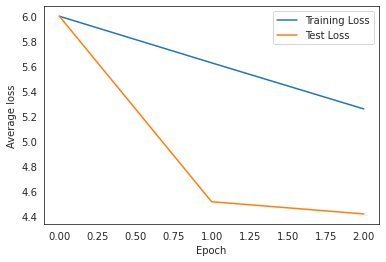

-------------------------------------------------------------------------------
Epoch starting at: 21:41:50
Epoch: 3, batch: 178/178, loss: 5.25414
Test Error:
Acc@1: 12.82%, Acc@5: 41.36%, Acc@10: 54.87%, Acc@20: 68.62% Avg loss: 4.358979
Epoch duration: 6:49


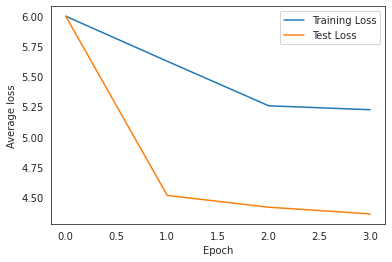

Current iteration 47/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Co

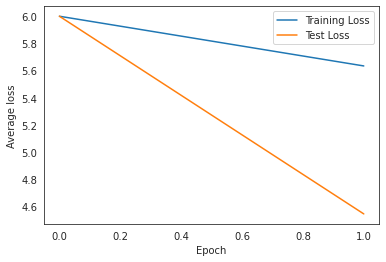

-------------------------------------------------------------------------------
Epoch starting at: 22:00:22
Epoch: 2, batch: 178/178, loss: 5.24794
Test Error:
Acc@1: 12.21%, Acc@5: 40.10%, Acc@10: 53.66%, Acc@20: 67.57% Avg loss: 4.415959
Epoch duration: 11:41


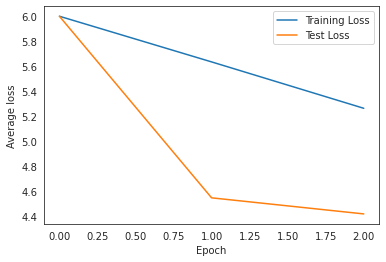

-------------------------------------------------------------------------------
Epoch starting at: 22:12:04
Epoch: 3, batch: 178/178, loss: 5.31363
Test Error:
Acc@1: 12.00%, Acc@5: 41.27%, Acc@10: 53.70%, Acc@20: 67.82% Avg loss: 4.408044
Epoch duration: 11:41


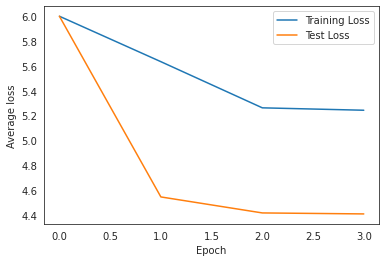

Current iteration 48/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

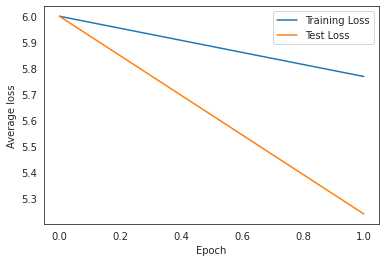

-------------------------------------------------------------------------------
Epoch starting at: 22:26:13
Epoch: 2, batch: 178/178, loss: 5.35044
Test Error:
Acc@1: 11.53%, Acc@5: 39.05%, Acc@10: 51.66%, Acc@20: 65.08% Avg loss: 4.635044
Epoch duration: 2:26


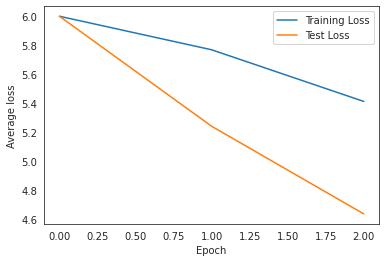

-------------------------------------------------------------------------------
Epoch starting at: 22:28:40
Epoch: 3, batch: 178/178, loss: 5.36796
Test Error:
Acc@1: 11.53%, Acc@5: 40.52%, Acc@10: 52.33%, Acc@20: 66.28% Avg loss: 4.592107
Epoch duration: 2:26


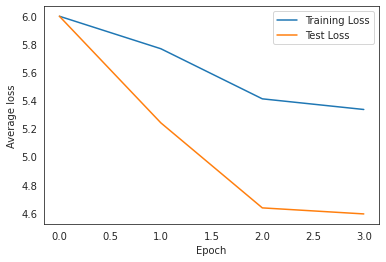

Current iteration 49/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

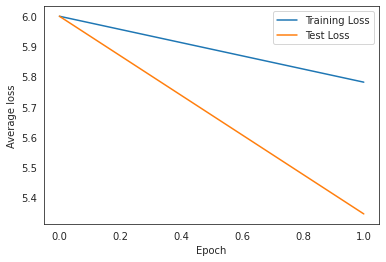

-------------------------------------------------------------------------------
Epoch starting at: 22:34:15
Epoch: 2, batch: 178/178, loss: 5.36882
Test Error:
Acc@1: 11.09%, Acc@5: 38.44%, Acc@10: 51.64%, Acc@20: 65.43% Avg loss: 4.639402
Epoch duration: 3:07


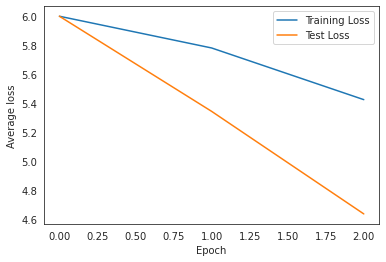

-------------------------------------------------------------------------------
Epoch starting at: 22:37:23
Epoch: 3, batch: 178/178, loss: 5.33483
Test Error:
Acc@1: 11.70%, Acc@5: 40.04%, Acc@10: 52.97%, Acc@20: 66.45% Avg loss: 4.580555
Epoch duration: 3:07


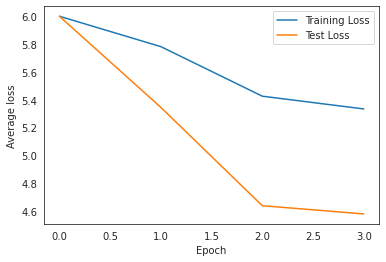

Current iteration 50/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

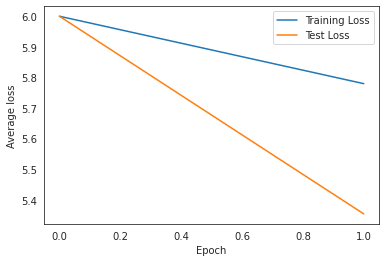

-------------------------------------------------------------------------------
Epoch starting at: 22:45:50
Epoch: 2, batch: 178/178, loss: 5.38593
Test Error:
Acc@1: 10.28%, Acc@5: 36.23%, Acc@10: 50.65%, Acc@20: 64.95% Avg loss: 4.654551
Epoch duration: 5:18


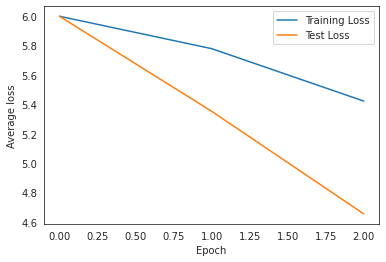

-------------------------------------------------------------------------------
Epoch starting at: 22:51:09
Epoch: 3, batch: 178/178, loss: 5.29456
Test Error:
Acc@1: 10.84%, Acc@5: 38.29%, Acc@10: 51.89%, Acc@20: 66.13% Avg loss: 4.594160
Epoch duration: 5:18


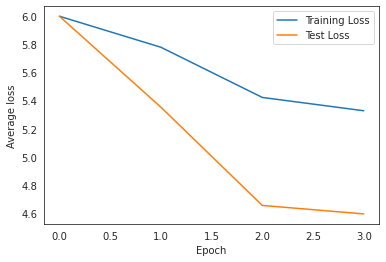

Current iteration 51/64
- Initial learning rate: 0.001
- Model: 

 XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4757, 5)
  (function_embedding): Embedding(2992, 25)
  (isco_code_embedding): Embedding(355, 25)
  (company_embedding): Embedding(441153, 25)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Con

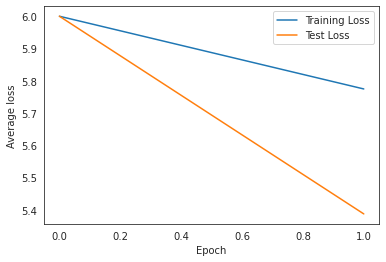

-------------------------------------------------------------------------------
Epoch starting at: 23:05:50
Epoch: 2, batch: 178/178, loss: 5.28179
Test Error:
Acc@1: 10.92%, Acc@5: 38.07%, Acc@10: 51.87%, Acc@20: 64.52% Avg loss: 4.661164
Epoch duration: 9:20


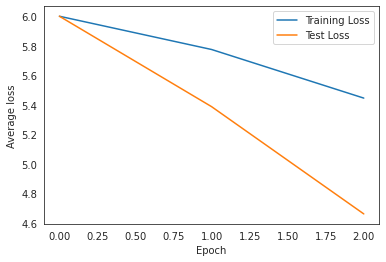

-------------------------------------------------------------------------------
Epoch starting at: 23:15:10


In [ ]:
num_epochs = 3
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-2, 1e-3, 1e-4][1:2]
window_sizes = [0.04, 0.08, 0.2, 0.4, 0.6, 0.8, 1.0][:4]
F1_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256][:4]
F2_sizes = [16, 32, 64, 128, 256][:4]

skill_embedding_size=15
certs_embedding_size=15
license_embedding_size=5
language_embedding_size=3
address_embedding_size=5
function_embedding_size=25
isco4_embedding_size=25
education_embedding_size=3
isco_level_embedding_size=3
company_embedding_size=25
w2v_embedding_size=30

try:            
    for learning_rate in learning_rates:
        for F1 in F1_sizes:
            for F2 in F2_sizes:
                for window_size in window_sizes:

                    cnn = XCM(num_classes=num_classes,
                              input_size=num_features,
                              F1=F1,
                              F2=F2,
                              window_size=window_size,
                              skills=skills, 
                              certs=certs,
                              licenses=licenses,
                              languages=languages,
                              addresses=addresses,
                              w2v=w2v,
                              skill_embedding_size=skill_embedding_size,
                              address_embedding_size=address_embedding_size,
                              function_embedding_size=function_embedding_size,
                              isco4_embedding_size=isco4_embedding_size,
                              company_embedding_size=company_embedding_size,
                              candidate_lengths=candidate_lens,
                              w2v_embedding_size=w2v_embedding_size,
                              max_len=max_len)

                    cnn = cnn.to(device)

                    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate, weight_decay=0.001)
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

                    print(f"Current iteration {current}/{len(learning_rates) * len(window_sizes) * len(F1_sizes) * len(F2_sizes)}")
                    print(f"- Initial learning rate: {learning_rate}\n- Model: \n\n", cnn, "\n")
                    
                    trainloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                                            weight_type=3, batch_size=512)

                    # Store results of current configuration
                    outcome = train_loop(cnn, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
                    outcome["lr"] = [learning_rate] * num_epochs
                    outcome["F1 size"] = [F1] * num_epochs
                    outcome["F2 size"] = [F2] * num_epochs
                    outcome["Window size"] = [window_size] * num_epochs

                    full_results.append(outcome)

                    current += 1

        break
except KeyboardInterrupt:
    pass

In [44]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "F1 size", "F2 size", "Window size", "Epoch"])

In [45]:
total

Acc@1     Acc@5    Acc@10  \
lr    F1 size F2 size Window size Epoch                                 
0.001 1       16      0.04        1      0.096900  0.326138  0.465861   
                                  2      0.108595  0.384172  0.514311   
                                  3      0.111893  0.398725  0.521521   
                      0.08        1      0.093383  0.232183  0.336294   
                                  2      0.109343  0.362453  0.503495   
...                                           ...       ...       ...   
      8       128     0.20        2      0.121345  0.407826  0.536909   
                                  3      0.127896  0.416267  0.545131   
                      0.40        1      0.129215  0.399648  0.538096   
                                  2      0.129523  0.411431  0.540163   
                                  3      0.134799  0.412442  0.541701   

                                           Acc@20  test_loss  training_loss  \
lr    F1 size F2 size Window size Epoch                                       
0.001 1       16      0.04        1      0.604441   5.196412       5.751458   
                                  2      0.657639   4.635139       5.405545   
                                  3      0.664410   4.593006       5.342695   
                      0.08        1      0.471312   5.358027       5.785833   
                                  2      0.648362   4.664504       5.428899   
...                                           ...        ...            ...   
      8       128     0.20        2      0.674830   4.411611       5.258383   
                                  3      0.680721   4.374874       5.230320   
                      0.40        1      0.671928   4.530880       5.623522   
                                  2      0.682656   4.370062       5.218215   
                                  3      0.683007   4.350028       5.166971   

                                         duration  
lr    F1 size F2 size Window size Epoch            
0.001 1       16      0.04        1           122  
                                  2           123  
                                  3           123  
                      0.08        1           139  
                                  2           139  
...                                           ...  
      8       128     0.20        2           488  
                                  3           488  
                      0.40        1           859  
                                  2           858  
                                  3           857  

[192 rows x 7 columns]

In [46]:
total.to_csv("../results/eCNN-results.csv")

Batch accuracy: 0.11328125

Majority class accuracy: 0.125
Majority class predictions: 0.291015625


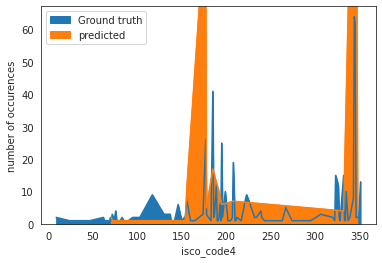

In [47]:
with torch.no_grad():
    for candidate, career, job in valloader:
        candidate, career, job = candidate.to(device), career.to(device), job.to(device)
        
        career = cnn.create_tensor(career)
        pred = cnn(career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())    
        print()

        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
        
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
        
        # Check how often the model predicted the previous job + compare to baseline performance
        print("Majority class accuracy:", (job == majority_class).cpu().numpy().mean())        
        print("Majority class predictions:", (pred.argmax(1) == majority_class).cpu().numpy().mean())
        
        plt.show()        
        break

In [63]:
del skills
del certs
del w2v
del languages
del to_fill

In [64]:
# x, isco_level, source, education, company_name, function_id, isco_code, w2v_list, skill_list, certs_list, license_list, langs_list, address_emb
feature_names = ["Time spent", "isco level", "education", "company name", "function", "isco code",
                 "cv", "skills", "certificates", "licenses", "languages", "location"]

# skill_embedding_size=50, certs_embedding_size=20,
# license_embedding_size=3, language_embedding_size=10,
# address_embedding_size=25, function_embedding_size=50, 
# isco4_embedding_size=25, education_embedding_size=3, 
# isco_level_embedding_size=3, company_embedding_size=50
source_embedding_size = 1
# w2v_embedding_size = 300

embedding_sizes= [0, 1, isco_level_embedding_size, education_embedding_size, company_embedding_size, 
                  function_embedding_size, isco4_embedding_size, w2v_embedding_size, skill_embedding_size, 
                  certs_embedding_size, license_embedding_size, language_embedding_size, address_embedding_size]

In [65]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [66]:
def merge_layers(output, embedding_sizes, axis="features"):
    """order: start=0, reg_features, isco_level_embedding_size, source_embedding_size, 
              education_embedding_size, company_embedding_size, function_embedding_size, 
              isco4_embedding_size, w2v_embedding_size, skill_embedding_size, 
              certs_embedding_size, license_embedding_size, language_embedding_size, 
              address_embedding_size"""
        
    if axis == "features":
        output = output.T
        idxs = np.cumsum(embedding_sizes)
        result = np.stack([output[idxs[i]:idxs[i+1]].mean(axis=0) for i in range(len(idxs) - 1)])
    elif axis == "time":
        result = output.sum(axis=1)
        # result = np.stack([result] * (len(embedding_sizes) - 1))
    else:
        return NotImplemented
        
    return result

In [67]:
def apply_gradcam(model, feature_layer, time_layer, batch, full_batch=True):
    
    # model.softmax = Identity()

    # Initialize gradcam
    cam = GradCAM(model=model, target_layers=[feature_layer], use_cuda=True)
    cam2 = GradCAM(model=model, target_layers=[time_layer], use_cuda=True)
        
    # Create batch
    c, i, j = batch

    # Convert batch to tensor
    i = cnn.create_tensor(i.to(device))
    
    # Only take first candidate from batch
    if not full_batch:
        for j in tqdm(range(len(i))):
            curr = i[j]
            curr = curr.unsqueeze(0)
            cam_result = cam(input_tensor=curr, targets=None)[0]
            cam_result2 = cam2(input_tensor=curr, targets=None)[0]
            
            if np.abs(cam_result).mean() != 0:
                return merge_layers(curr[0].cpu().detach(), embedding_sizes), cam_result, cam_result2
        return merge_layers(i[0].cpu().detach(), embedding_sizes), cam(input_tensor=i[0], targets=None)[0], cam2(input_tensor=curr, targets=None)[0]
    else:
        return merge_layers(i.cpu().detach().mean(axis=0), embedding_sizes), cam(input_tensor=i, targets=None).sum(axis=0), cam2(input_tensor=i, targets=None).sum(axis=0)

In [85]:
def visualize_gradients(model, feature_layer, time_layer, batch, full_batch=True):
    values, cam, cam2 = apply_gradcam(model, feature_layer, time_layer, batch, full_batch=full_batch)
    
    to_plot = merge_layers(cam, embedding_sizes, axis="features")
    time = merge_layers(cam2, embedding_sizes, axis="time")
    
    if time.max() != 0:
        time /= time.sum()
       
    if to_plot.max() != 0:
        # to_plot = (to_plot - to_plot.min()) / (to_plot.max() - to_plot.min())
        to_plot /= to_plot.max()
        
    values = merge_layers(values.T, embedding_sizes)
    
    # Sum each feature over the time dimension and normalize    
    feature_weight = to_plot.T.sum(axis=0)    
    # feature_weight *= (values.T.sum(axis=0) != 0)
    feature_weight /= feature_weight.sum()
    
    # Normalized feature attention 
    series = pd.Series(feature_weight, index=feature_names).sort_values(ascending=False)    
    
    # Create grid
    fig = plt.figure(figsize=(20, 12))
    grid = plt.GridSpec(2, 2, wspace=0.1, hspace=0.3)
    grid.update(top=0.95)

    ax1 = plt.subplot(grid[0, 0])
    ax2 = plt.subplot(grid[0, 1])
    ax3 = plt.subplot(grid[1, :])
    # ax4 = plt.subplot(grid[2, :2])
    
    fig.suptitle("Attention types")

    # Plot total attention for each feature
    sns.barplot(x=series.index, y=series.values, ax=ax1)
    ax1.set_xticklabels(labels=series.index, rotation=90)
    ax1.set_ylabel("Gradient")
    ax1.set_title("Attention per feature")
    
    ax2.plot(time)
    ax2.set_title("Attention per time step")
    ax2.set_ylabel("Attention score")
    ax2.set_xlabel("Time step")
    
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
        
    # Normalize gradients
    to_plot *= (values.sum(axis=0) != 0)
    to_plot /= to_plot.max() 
    
    sns.heatmap(to_plot, cmap=cmap, xticklabels=range(1, 26), yticklabels=feature_names, 
                cbar_kws={'label': 'Gradient'}, linewidths=0.1, ax=ax3)
    
    ax3.set_title("Spatiotemporal attention")
    ax3.set_xlabel("Time step")
    
    fig.savefig("Visualisations/eCNN.pdf");

In [128]:
batch = next(iter(valloader))

  0%|          | 0/512 [00:00<?, ?it/s]
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: Mean of empty slice.
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


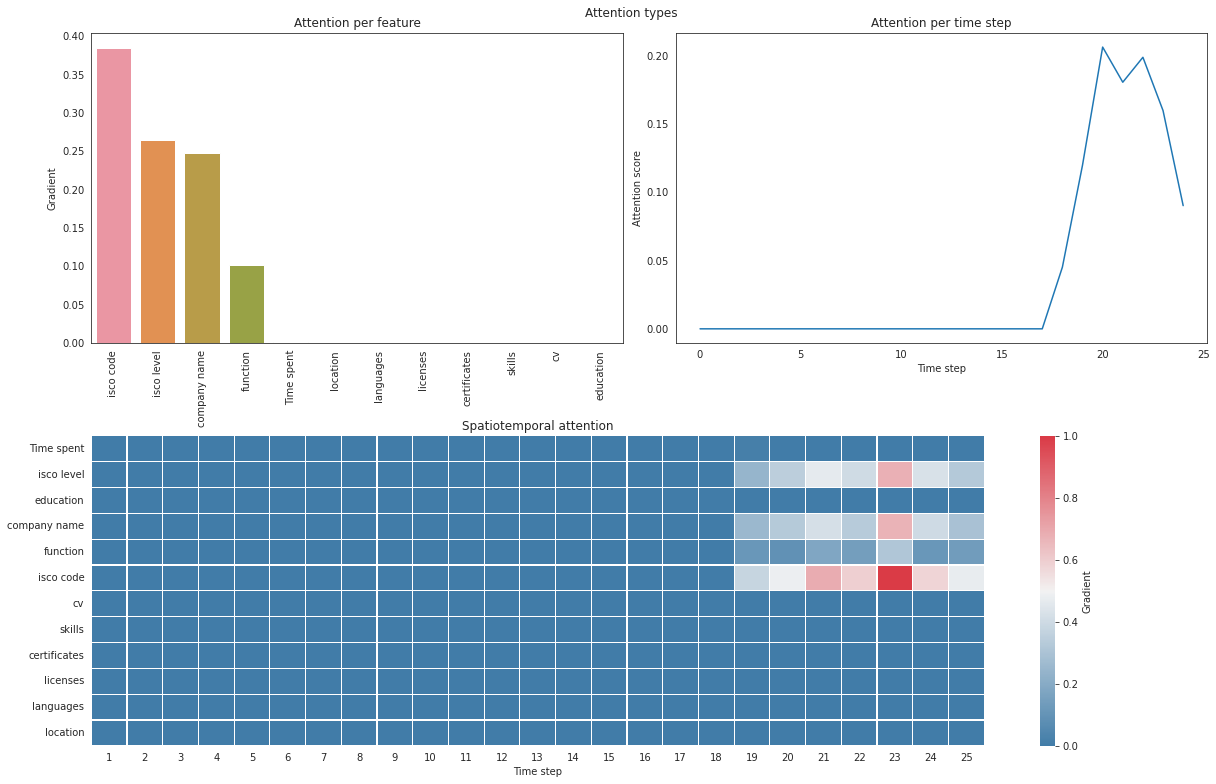

In [157]:
batch = next(iter(valloader))
visualize_gradients(cnn, cnn.conv2d, cnn.conv1d, batch, full_batch=False)